<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/SAE_mnist_left_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1jldVMz98YxZkAnjFq2LpDQO2o5gNXbj7#scrollTo=nkXNP5mLqSEn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import torch
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu")

In [3]:
# Define the custom AlexNet model
class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # 96*55*55 (for 224x224 input)
            nn.MaxPool2d(kernel_size=3, stride=2),  # 96*27*27
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # 256*27*27
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*13*13
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 256*13*13
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*6*6
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(256 * 1 * 1, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)  # Modify to 2 if classifying 2 classes but we are using a similar approach to other papers

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [4]:
# Set seed for reproducibility
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call set_seed at the beginning of the script to ensure reproducibility
set_seed(42)


# Step 1: Preprocess images, extract or load activations

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        print(f"Initializing dataset with {len(image_paths)} images")
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        print(f"Loading image: {image_path}")
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

def load_model(model_path):
    print(f"Loading model from {model_path}")
    model = AlexNet()
    #model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])




def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to custom AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activations.append(tensor.cpu().numpy())

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    print(f"Extracted activations for {len(activations)} images")
    return activations


def process_images_in_folder(model, folder_path, layer, batch_size=1):  # Set batch_size=1 to avoid batch aggregation
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    print("Flattening and aligning activations")
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    print(f"Aligned activations to shape: {np.vstack(aligned_activations).shape}")
    return np.vstack(aligned_activations)

def save_activations(activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/{folder_name}/{filename}.npy'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    print(f"Saving activations to {drive_path}")
    np.save(drive_path, activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/{folder_name}/{filename}.npy'
    print(f"Loading activations from {drive_path}")
    return np.load(drive_path, allow_pickle=True)

# Modify the compute_activations_for_layers function to average activations across models
def compute_activations_for_layers(model_paths, folder_paths, layers, activations_file_prefix):
    # Initialize the dictionary with all keys in folder_paths
    all_layer_activations = {layer: {key: [] for key in folder_paths.keys()} for layer in layers}

    # Loop through folder paths (e.g., 'wb_patch', 'wb_no_patch', etc.)
    for folder_name, folder_path in folder_paths.items():
        print(f"Processing folder {folder_name}")

        for layer in layers:
            combined_activations = None  # To store the sum of activations across models

            # Process activations for each model
            for model_idx, model_path in enumerate(model_paths):
                print(f"Processing model {model_idx + 1}/{len(model_paths)}")
                model = load_model(model_path)

                # Compute activations for the folder
                activations = process_images_in_folder(model, folder_path, layer)
                activations = flatten_and_align_activations(activations)

                # Accumulate activations across models
                if combined_activations is None:
                    combined_activations = np.array(activations, dtype=np.float32)
                else:
                    combined_activations += np.array(activations, dtype=np.float32)

                # Free resources
                del model
                torch.cuda.empty_cache()
                gc.collect()

            # Average activations across models
            averaged_activations = combined_activations / len(model_paths)
            all_layer_activations[layer][folder_name].append(averaged_activations)

            # Save averaged activations
            save_activations(averaged_activations, f'layer_{layer}', f'{activations_file_prefix}_{folder_name}')

    return all_layer_activations

# Step 2: Extract Training Activations

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_111train.pt"
]

layers_of_interest = [5, 6]
'''
# Paths to training data
folder_paths = {
    #'two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2',
    #'zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half',
    'zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'
}

# Extract and save averaged training activations across three models
train_activations = compute_activations_for_layers(model_paths, folder_paths, layers_of_interest, 'train')

'''

"\n# Paths to training data\nfolder_paths = {\n    #'two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2',\n    #'zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half',\n    'zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'\n}\n\n# Extract and save averaged training activations across three models\ntrain_activations = compute_activations_for_layers(model_paths, folder_paths, layers_of_interest, 'train')\n\n"

In [5]:
'''
import os
import numpy as np

def swap_and_rename(layer, filename1, filename2):
    # Paths to the original files for the specific layer
    path1 = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{filename1}.npy'
    path2 = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{filename2}.npy'

    # Check if both files exist
    if not os.path.exists(path1):
        print(f"File {path1} does not exist!")
        return
    if not os.path.exists(path2):
        print(f"File {path2} does not exist!")
        return

    # Load the activations from both files
    print(f"Loading activations from {path1} and {path2}")
    activations1 = np.load(path1, allow_pickle=True)
    activations2 = np.load(path2, allow_pickle=True)

    # Swap the activations
    print(f"Swapping activations between {filename1} and {filename2} for layer {layer}")
    np.save(path1, activations2)  # Save activations2 to path1
    np.save(path2, activations1)  # Save activations1 to path2

    print(f"Swapped activations and saved them back to {path1} and {path2}")

# List of layers to fix
layers = [5, 6]  # Add more layers if needed

# Iterate through each layer and swap the activations
for layer in layers:
    swap_and_rename(layer, 'train_zero_patch', 'train_zero_no_patch')

print("Swapping completed for all specified layers.")
'''

'\nimport os\nimport numpy as np\n\ndef swap_and_rename(layer, filename1, filename2):\n    # Paths to the original files for the specific layer\n    path1 = f\'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{filename1}.npy\'\n    path2 = f\'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{filename2}.npy\'\n\n    # Check if both files exist\n    if not os.path.exists(path1):\n        print(f"File {path1} does not exist!")\n        return\n    if not os.path.exists(path2):\n        print(f"File {path2} does not exist!")\n        return\n\n    # Load the activations from both files\n    print(f"Loading activations from {path1} and {path2}")\n    activations1 = np.load(path1, allow_pickle=True)\n    activations2 = np.load(path2, allow_pickle=True)\n\n    # Swap the activations\n    print(f"Swapping activations between {filename1} and {filename2} for layer {layer}")\n    np.save(path1, activatio

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
import gc
'''
# Step 1: Load the activations from Google Drive
def load_saved_activations(layer, subset, activations_file_prefix):
    # Define the path where activations were saved on Google Drive
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{activations_file_prefix}_{subset}.npy'
    print(f"Loading activations from {drive_path}")

    # Load the saved .npy file from the path
    if os.path.exists(drive_path):
        activations = np.load(drive_path, allow_pickle=True)
        print(f"Loaded activations for layer {layer}, subset {subset}. Shape: {activations.shape}")
        return activations
    else:
        print(f"Activations file {drive_path} does not exist.")
        return None

# Step 2: Define Sparse Autoencoder with KL-divergence
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda=1e-3, sparsity_target=0.10, xavier_norm_init=True):
        super(SparseAutoencoder, self).__init__()
        self.in_dims = in_dims  # Input dimension (number of neurons in the input layer)
        self.h_dims = h_dims  # Hidden dimension (number of neurons in the hidden layer)
        self.sparsity_lambda = sparsity_lambda  # Weight for the sparsity penalty term
        self.sparsity_target = sparsity_target  # Target sparsity (desired average activation)

        # Encoder: Projects input to the hidden (sparse) space
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dims, self.h_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)  # Xavier initialization

        # Decoder: Reconstructs the input from the hidden (sparse) representation
        self.decoder = nn.Sequential(
            nn.Linear(self.h_dims, self.in_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)

    # Forward pass through the encoder and decoder
    def forward(self, x):
        encoded = self.encoder(x)  # Pass input through encoder
        decoded = self.decoder(encoded)  # Pass encoded (sparse) representation through decoder
        return encoded, decoded

    # KL-divergence sparsity penalty calculation
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)  # Compute the average activation for each hidden neuron
        rho = torch.ones_like(rho_hat) * self.sparsity_target  # Target sparsity value
        epsilon = 1e-8  # Small value to avoid log(0)
        kl_divergence = F.kl_div((rho_hat + epsilon).log(), rho + epsilon, reduction='batchmean')  # KL-divergence
        return self.sparsity_lambda * kl_divergence  # Return the sparsity penalty, weighted by lambda

    # Loss function combining MSE (reconstruction error) and sparsity penalty
    def loss_function(self, decoded, original, encoded):
        mse_loss = F.mse_loss(decoded, original)  # Mean Squared Error for reconstruction
        sparsity_loss = self.sparsity_penalty(encoded)  # Sparsity penalty for hidden layer activations
        return mse_loss + sparsity_loss  # Total loss is MSE + sparsity penalty


# Early stopping mechanism to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.best_loss = None  # Best validation loss observed so far
        self.counter = 0  # Counter to keep track of how many epochs since the last improvement

    # Check if training should be stopped based on validation loss
    def check(self, loss):
        if self.best_loss is None:
            self.best_loss = loss  # Set the initial best loss
            return False

        # If the loss has improved significantly
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss  # Update best loss
            self.counter = 0  # Reset counter
            return False
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                print("Early stopping triggered.")  # Stop training if patience is exceeded
                return True
        return False


# Training Function with Loss Tracking and Plotting
def train_autoencoder(autoencoder, data, num_epochs=100, batch_size=128, learning_rate=1e-5, validation_split=0.2, clip_gradients=True, max_grad_norm=0.5):
    print(f"Training autoencoder with input dim {data.shape[1]} and encoding dim {autoencoder.h_dims}")

    # Split the data into training and validation sets
    num_train = int((1 - validation_split) * len(data))  # Compute the number of training samples
    train_data = data[:num_train]  # Training data
    val_data = data[num_train:]  # Validation data

    # Create PyTorch datasets and dataloaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data).float())
    val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_data).float())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Adam optimizer with learning rate and weight decay for regularization
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-2)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    # Lists to store training and validation loss values
    train_losses = []
    val_losses = []

    # Start training loop
    autoencoder.train()  # Set the autoencoder in training mode
    for epoch in range(num_epochs):
        total_train_loss = 0  # Initialize training loss for the current epoch

        # Iterate over batches in the training set
        for x_batch, in train_loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()  # Zero the gradients
            encoded, decoded = autoencoder(x_batch)  # Forward pass through autoencoder
            loss = autoencoder.loss_function(decoded, x_batch, encoded)  # Compute the loss
            loss.backward()  # Backpropagate the error

            # Apply gradient clipping if enabled
            if clip_gradients:
                torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_grad_norm)

            optimizer.step()  # Update the weights using the optimizer
            total_train_loss += loss.item()  # Accumulate training loss for this batch

        # Validation step after each epoch
        total_val_loss = 0  # Initialize validation loss
        autoencoder.eval()  # Set the autoencoder in evaluation mode
        with torch.no_grad():  # No gradient calculation in validation mode
            for x_batch, in val_loader:
                x_batch = x_batch.to(device)
                encoded, decoded = autoencoder(x_batch)
                loss = autoencoder.loss_function(decoded, x_batch, encoded)
                total_val_loss += loss.item()

        # Compute the average training and validation loss for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        # Store the loss values for plotting later
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress for the current epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

        # Check early stopping condition based on validation loss
        if early_stopping.check(avg_val_loss):
            break

    print("Autoencoder training completed")

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return autoencoder


'''

'\n# Step 1: Load the activations from Google Drive\ndef load_saved_activations(layer, subset, activations_file_prefix):\n    # Define the path where activations were saved on Google Drive\n    drive_path = f\'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{activations_file_prefix}_{subset}.npy\'\n    print(f"Loading activations from {drive_path}")\n\n    # Load the saved .npy file from the path\n    if os.path.exists(drive_path):\n        activations = np.load(drive_path, allow_pickle=True)\n        print(f"Loaded activations for layer {layer}, subset {subset}. Shape: {activations.shape}")\n        return activations\n    else:\n        print(f"Activations file {drive_path} does not exist.")\n        return None\n\n# Step 2: Define Sparse Autoencoder with KL-divergence\nclass SparseAutoencoder(nn.Module):\n    def __init__(self, in_dims, h_dims, sparsity_lambda=1e-3, sparsity_target=0.10, xavier_norm_init=True):\n        super(SparseAut

In [7]:
'''
# Paths and Layers Definition
save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/Autoencoders/'  # Directory to save the trained autoencoder
os.makedirs(save_sae_dir, exist_ok=True)

layers_of_interest = [5, 6]  # Define which layers' activations to train autoencoders on

# Step 3: Load the preprocessed activations from drive and train the autoencoders
for layer in layers_of_interest:
    print(f'\nTraining autoencoder for layer {layer}')

    activations_list = []
    for subset in ['two_no_patch', 'zero_no_patch', 'zero_patch']:
        # Load activations for each subset and layer
        activations = load_saved_activations(layer, subset, 'train')
        if activations is not None:
            activations_list.append(activations)

    # Check if activations were loaded correctly
    if len(activations_list) == 0:
        print(f"No activations found for layer {layer}. Skipping...")
        continue

    # Concatenate all activations for this layer into a single array
    combined_activations = np.vstack(activations_list)
    print(f"Combined activations shape for layer {layer}: {combined_activations.shape}")

    # Print the number of combined activations (i.e., number of samples)
    num_combined_activations = combined_activations.shape[0]
    print(f"Number of combined activations (samples): {num_combined_activations}")

    # Set the encoding dimension (hidden layer size) as 2 times the number of combined activations
    encoding_dim = min(num_combined_activations * 2, 8192)  # Cap the encoding dim at 8192 also use it for later experimentations on oter layers
    print(f"Setting encoding dimension (h_dim) as: {encoding_dim}")

    # Input dimension is the number of neurons in the original input layer
    input_dim = combined_activations.shape[1]

    # Initialize the autoencoder with the specified input and hidden dimensions
    autoencoder = SparseAutoencoder(input_dim, encoding_dim).to(device)

    # Train the autoencoder on the combined activations
    print(f"Training autoencoder for layer {layer}")
    autoencoder = train_autoencoder(
        autoencoder,
        combined_activations,  # unnormalized activations
        num_epochs=100,
        learning_rate=1e-5
    )

    # Save the trained autoencoder
    save_path = os.path.join(save_sae_dir, f'autoencoder_layer_{layer}.pth')
    torch.save(autoencoder.state_dict(), save_path)
    print(f"Autoencoder for layer {layer} saved at {save_path}")

    # Clear memory after saving
    del combined_activations, autoencoder
    gc.collect()
    torch.cuda.empty_cache()

print("\nAll autoencoders trained and saved successfully.")
'''

'\n# Paths and Layers Definition\nsave_sae_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/Autoencoders/\'  # Directory to save the trained autoencoder\nos.makedirs(save_sae_dir, exist_ok=True)\n\nlayers_of_interest = [5, 6]  # Define which layers\' activations to train autoencoders on\n\n# Step 3: Load the preprocessed activations from drive and train the autoencoders\nfor layer in layers_of_interest:\n    print(f\'\nTraining autoencoder for layer {layer}\')\n\n    activations_list = []\n    for subset in [\'two_no_patch\', \'zero_no_patch\', \'zero_patch\']:\n        # Load activations for each subset and layer\n        activations = load_saved_activations(layer, subset, \'train\')\n        if activations is not None:\n            activations_list.append(activations)\n\n    # Check if activations were loaded correctly\n    if len(activations_list) == 0:\n        print(f"No activations found for layer {layer}. Skipping...")\n        continue\n\n    # 

In [16]:
import os
import numpy as np
import pandas as pd

def load_activations_and_save_as_csv(layer, subset):
    # Define the paths for the .npy file and the target .csv file
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{subset}.npy'
    csv_save_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/layer_{layer}_{subset}.csv'

    # Load the activations from the .npy file
    if os.path.exists(drive_path):
        activations = np.load(drive_path, allow_pickle=True)

        # Print the shape of the activations
        num_images, num_neurons = activations.shape
        print(f"Loaded activations for layer {layer}, subset {subset}:")
        print(f"Number of images: {num_images}, Number of neurons per layer per image: {num_neurons}")

        # Convert the activations to a Pandas DataFrame
        df = pd.DataFrame(activations)

        # Create directory for CSV output if it doesn't exist
        os.makedirs(os.path.dirname(csv_save_path), exist_ok=True)

        # Save the DataFrame as a CSV file
        df.to_csv(csv_save_path, index=False)
        print(f"Activations saved as CSV at: {csv_save_path}")
    else:
        print(f"Activations file {drive_path} does not exist.")


# Define layers and subsets to convert activations to CSV
layers_of_interest = [5, 6]
subsets = ['test_two_patch', 'test_two_no_patch']

# Loop through each layer and subset to load and save the activations as CSV
for layer in layers_of_interest:
    for subset in subsets:
        load_activations_and_save_as_csv(layer, subset)


Activations file /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_5/test_two_patch.npy does not exist.
Activations file /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_5/test_two_no_patch.npy does not exist.
Activations file /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_6/test_two_patch.npy does not exist.
Activations file /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_6/test_two_no_patch.npy does not exist.



Training autoencoder for layer 5
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_5/train_two_no_patch.npy
Loaded activations for layer 5, subset two_no_patch. Shape: (5958, 4096)
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_5/train_zero_no_patch.npy
Loaded activations for layer 5, subset zero_no_patch. Shape: (5923, 4096)
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_5/train_zero_patch.npy
Loaded activations for layer 5, subset zero_patch. Shape: (5923, 4096)
Combined activations shape for layer 5: (17804, 4096)
Number of combined activations (samples): 17804
Setting encoding dimension (h_dim) as: 8192
Training autoencoder for layer 5
Training autoencoder with input dim 4096 and encoding dim 8192
Epoch 1/100, Train Loss: 0.6338244724486556, Val Loss: 0.37935584251369747
Epoch 2/100, Train

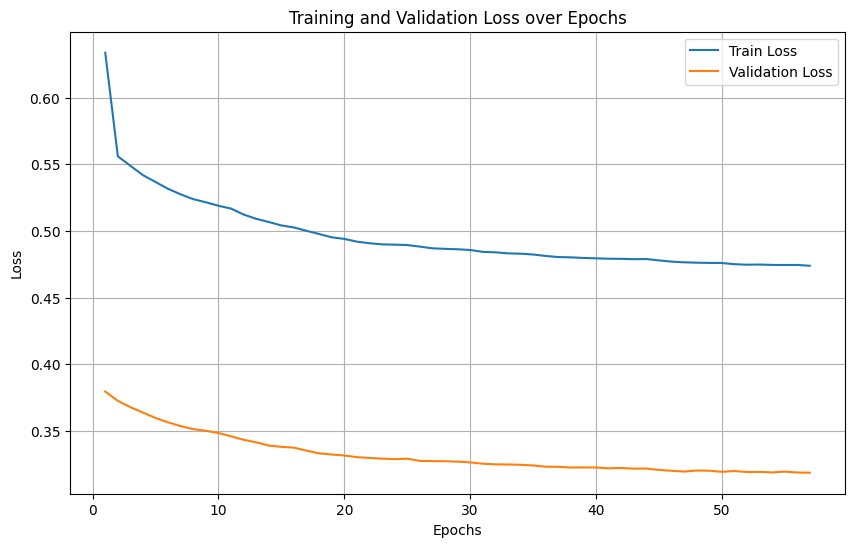

Autoencoder for layer 5 saved at /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/Autoencoders/autoencoder_layer_5.pth
Plotting activations for layer 5


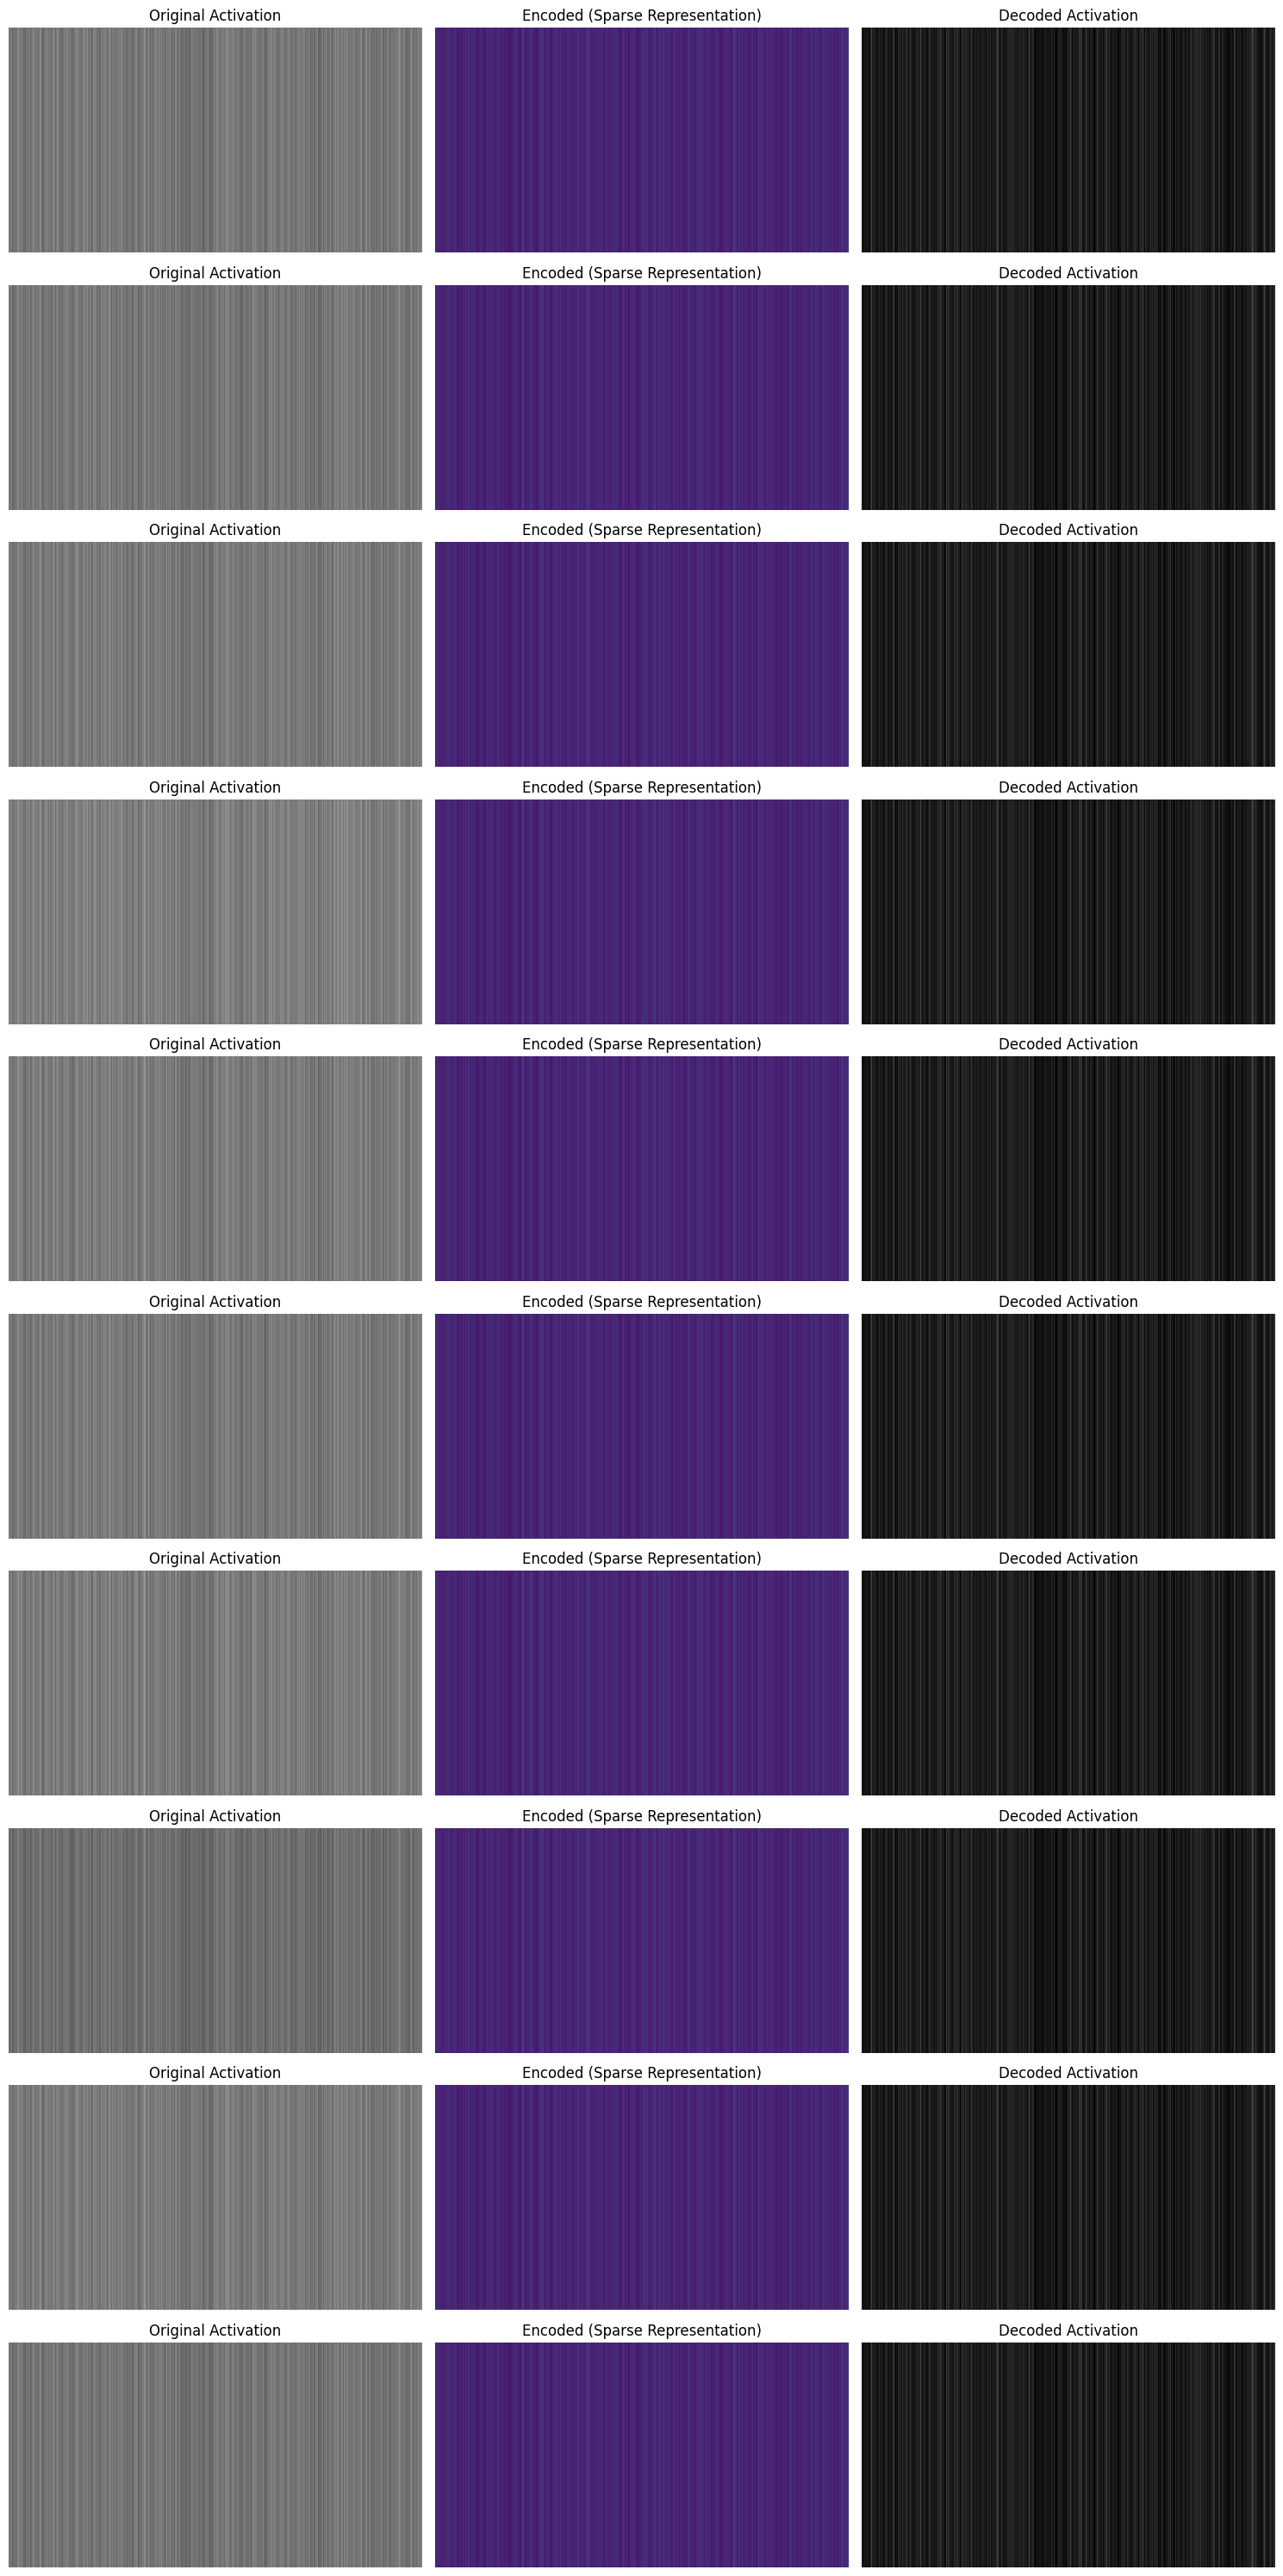


Training autoencoder for layer 6
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_6/train_two_no_patch.npy
Loaded activations for layer 6, subset two_no_patch. Shape: (5958, 4096)
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_6/train_zero_no_patch.npy
Loaded activations for layer 6, subset zero_no_patch. Shape: (5923, 4096)
Loading activations from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_6/train_zero_patch.npy
Loaded activations for layer 6, subset zero_patch. Shape: (5923, 4096)
Combined activations shape for layer 6: (17804, 4096)
Number of combined activations (samples): 17804
Setting encoding dimension (h_dim) as: 8192
Training autoencoder for layer 6
Training autoencoder with input dim 4096 and encoding dim 8192
Epoch 1/100, Train Loss: 1.3796931079455785, Val Loss: 0.8143629665885653
Epoch 2/100, Train 

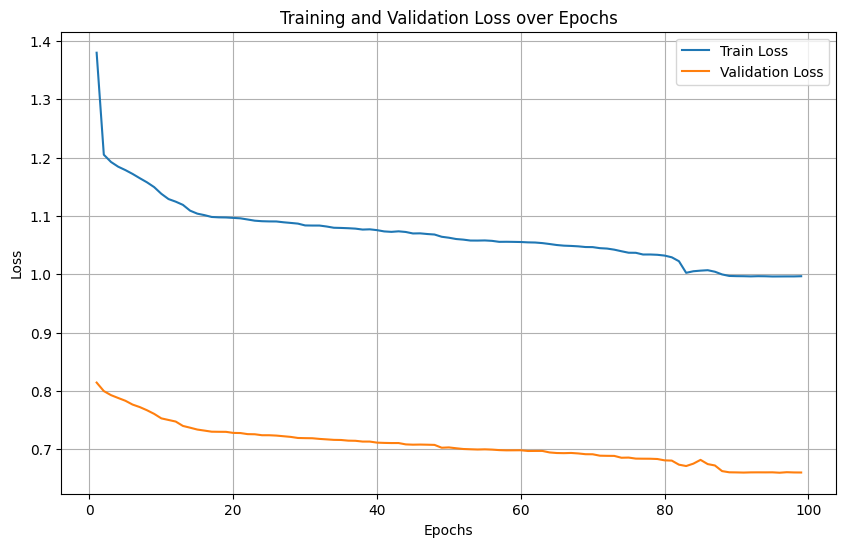

Autoencoder for layer 6 saved at /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/Autoencoders/autoencoder_layer_6.pth
Plotting activations for layer 6


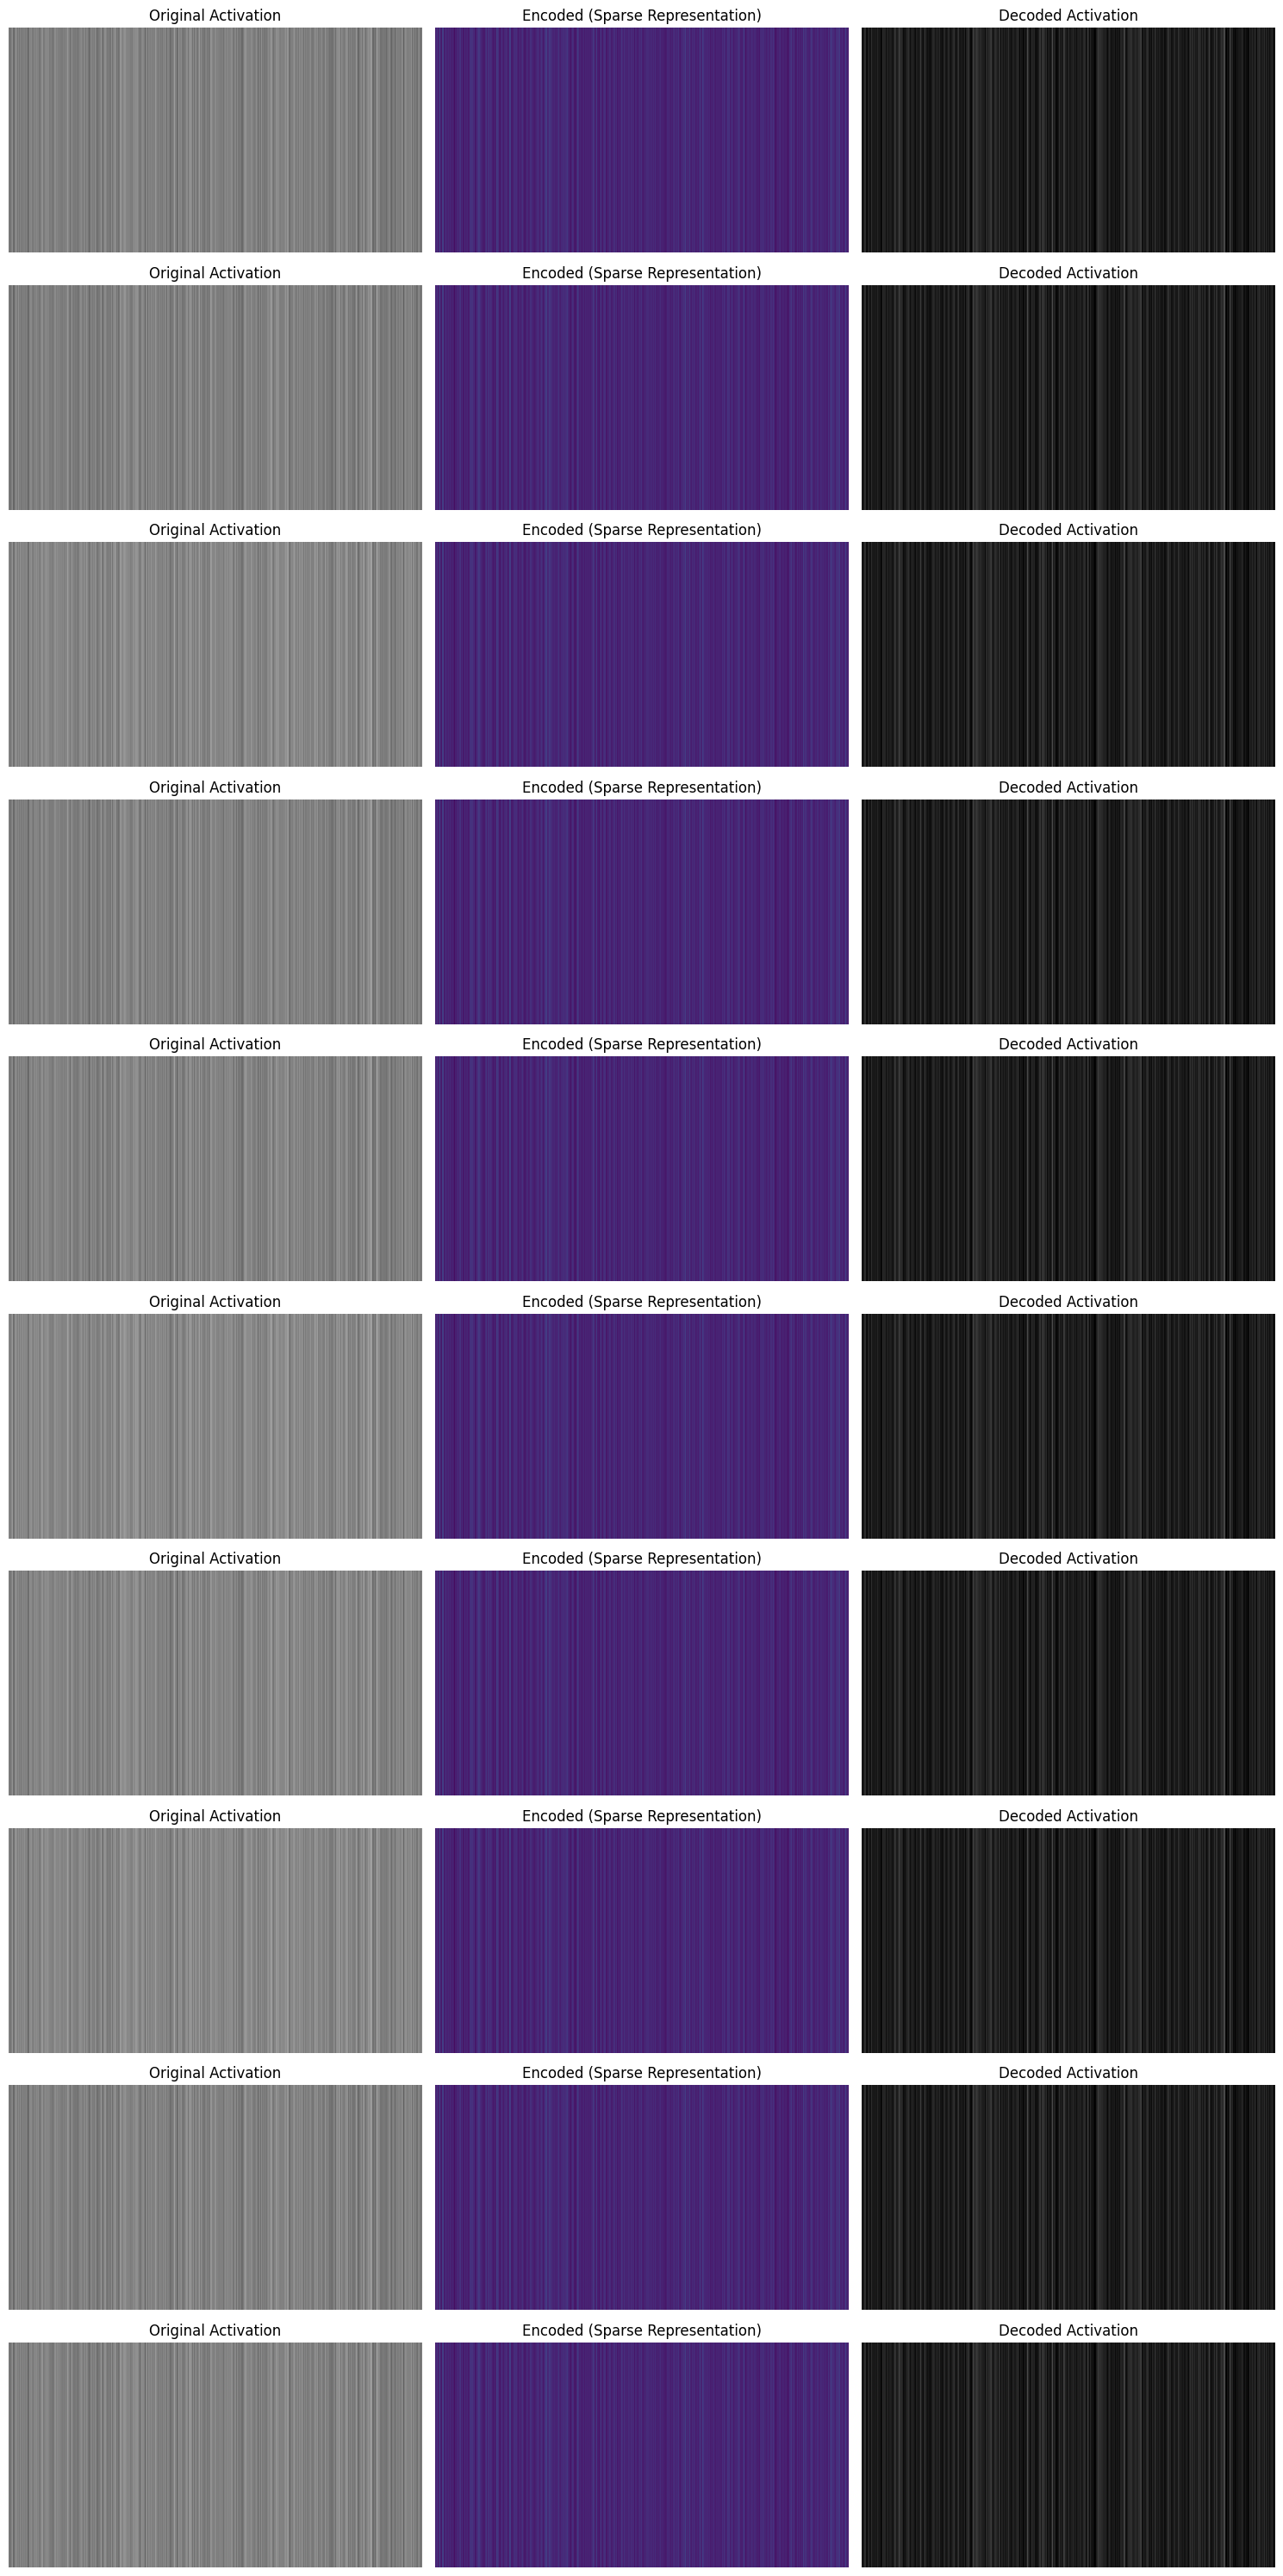


All autoencoders trained and saved successfully.


In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
import gc
import matplotlib.pyplot as plt

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load the activations from Google Drive
def load_saved_activations(layer, subset, activations_file_prefix):
    # Define the path where activations were saved on Google Drive
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/average/layer_{layer}/{activations_file_prefix}_{subset}.npy'
    print(f"Loading activations from {drive_path}")

    # Load the saved .npy file from the path
    if os.path.exists(drive_path):
        activations = np.load(drive_path, allow_pickle=True)
        print(f"Loaded activations for layer {layer}, subset {subset}. Shape: {activations.shape}")
        return activations
    else:
        print(f"Activations file {drive_path} does not exist.")
        return None

# Step 2: Define Sparse Autoencoder with KL-divergence
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda=1e-3, sparsity_target=0.10, xavier_norm_init=True):
        super(SparseAutoencoder, self).__init__()
        self.in_dims = in_dims  # Input dimension (number of neurons in the input layer)
        self.h_dims = h_dims  # Hidden dimension (number of neurons in the hidden layer)
        self.sparsity_lambda = sparsity_lambda  # Weight for the sparsity penalty term
        self.sparsity_target = sparsity_target  # Target sparsity (desired average activation)

        # Encoder: Projects input to the hidden (sparse) space
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dims, self.h_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)  # Xavier initialization

        # Decoder: Reconstructs the input from the hidden (sparse) representation
        self.decoder = nn.Sequential(
            nn.Linear(self.h_dims, self.in_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)

    # Forward pass through the encoder and decoder
    def forward(self, x):
        encoded = self.encoder(x)  # Pass input through encoder
        decoded = self.decoder(encoded)  # Pass encoded (sparse) representation through decoder
        return encoded, decoded

    # KL-divergence sparsity penalty calculation
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)  # Compute the average activation for each hidden neuron
        rho = torch.ones_like(rho_hat) * self.sparsity_target  # Target sparsity value
        epsilon = 1e-8  # Small value to avoid log(0)
        kl_divergence = F.kl_div((rho_hat + epsilon).log(), rho + epsilon, reduction='batchmean')  # KL-divergence
        return self.sparsity_lambda * kl_divergence  # Return the sparsity penalty, weighted by lambda

    # Loss function combining MSE (reconstruction error) and sparsity penalty
    def loss_function(self, decoded, original, encoded):
        mse_loss = F.mse_loss(decoded, original)  # Mean Squared Error for reconstruction
        sparsity_loss = self.sparsity_penalty(encoded)  # Sparsity penalty for hidden layer activations
        return mse_loss + sparsity_loss  # Total loss is MSE + sparsity penalty

# Early stopping mechanism to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.best_loss = None  # Best validation loss observed so far
        self.counter = 0  # Counter to keep track of how many epochs since the last improvement

    # Check if training should be stopped based on validation loss
    def check(self, loss):
        if self.best_loss is None:
            self.best_loss = loss  # Set the initial best loss
            return False

        # If the loss has improved significantly
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss  # Update best loss
            self.counter = 0  # Reset counter
            return False
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                print("Early stopping triggered.")  # Stop training if patience is exceeded
                return True
        return False

# Training Function with Loss Tracking and Plotting
def train_autoencoder(autoencoder, data, num_epochs=100, batch_size=128, learning_rate=1e-5, validation_split=0.2, clip_gradients=True, max_grad_norm=0.5):
    print(f"Training autoencoder with input dim {data.shape[1]} and encoding dim {autoencoder.h_dims}")

    # Split the data into training and validation sets
    num_train = int((1 - validation_split) * len(data))  # Compute the number of training samples
    train_data = data[:num_train]  # Training data
    val_data = data[num_train:]  # Validation data

    # Create PyTorch datasets and dataloaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data).float())
    val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_data).float())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Adam optimizer with learning rate and weight decay for regularization
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-2)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    # Lists to store training and validation loss values
    train_losses = []
    val_losses = []

    # Start training loop
    autoencoder.train()  # Set the autoencoder in training mode
    for epoch in range(num_epochs):
        total_train_loss = 0  # Initialize training loss for the current epoch

        # Iterate over batches in the training set
        for x_batch, in train_loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()  # Zero the gradients
            encoded, decoded = autoencoder(x_batch)  # Forward pass through autoencoder
            loss = autoencoder.loss_function(decoded, x_batch, encoded)  # Compute the loss
            loss.backward()  # Backpropagate the error

            # Apply gradient clipping if enabled
            if clip_gradients:
                torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_grad_norm)

            optimizer.step()  # Update the weights using the optimizer
            total_train_loss += loss.item()  # Accumulate training loss for this batch

        # Validation step after each epoch
        total_val_loss = 0  # Initialize validation loss
        autoencoder.eval()  # Set the autoencoder in evaluation mode
        with torch.no_grad():  # No gradient calculation in validation mode
            for x_batch, in val_loader:
                x_batch = x_batch.to(device)
                encoded, decoded = autoencoder(x_batch)
                loss = autoencoder.loss_function(decoded, x_batch, encoded)
                total_val_loss += loss.item()

        # Compute the average training and validation loss for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        # Store the loss values for plotting later
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress for the current epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

        # Check early stopping condition based on validation loss
        if early_stopping.check(avg_val_loss):
            break

    print("Autoencoder training completed")

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return autoencoder

# Function to plot the encoder and decoder activations
def plot_encoder_decoder_activations(autoencoder, activations, num_samples=10):
    autoencoder.eval()  # Set the autoencoder to evaluation mode
    with torch.no_grad():
        # Convert the activations to a torch tensor
        activations_tensor = torch.from_numpy(activations[:num_samples]).float().to(device)

        # Pass through the autoencoder
        encoded, decoded = autoencoder(activations_tensor)

        # Move tensors to CPU for plotting
        encoded = encoded.cpu().numpy()
        decoded = decoded.cpu().numpy()

    # Plotting the original activations, encoded activations, and decoded activations
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

    for i in range(num_samples):
        # Plot original activations as a vector or heatmap
        # Here, we're assuming activations are 1D vectors, e.g., from FC layers
        if len(activations[i].shape) == 1:
            axes[i, 0].imshow(activations[i].reshape(1, -1), aspect='auto', cmap='gray')
        else:
            axes[i, 0].imshow(activations[i], cmap='gray')
        axes[i, 0].set_title("Original Activation")
        axes[i, 0].axis('off')

        # Plot encoded activations as a heatmap
        axes[i, 1].imshow(encoded[i].reshape(1, -1), aspect='auto', cmap='viridis')
        axes[i, 1].set_title("Encoded (Sparse Representation)")
        axes[i, 1].axis('off')

        # Plot decoded activations as a vector or heatmap
        if len(decoded[i].shape) == 1:
            axes[i, 2].imshow(decoded[i].reshape(1, -1), aspect='auto', cmap='gray')
        else:
            axes[i, 2].imshow(decoded[i], cmap='gray')
        axes[i, 2].set_title("Decoded Activation")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Paths and Layers Definition
save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/Autoencoders/'  # Directory to save the trained autoencoder
os.makedirs(save_sae_dir, exist_ok=True)

layers_of_interest = [5, 6]  # Define which layers' activations to train autoencoders on

# Step 3: Load the preprocessed activations from drive and train the autoencoders
for layer in layers_of_interest:
    print(f'\nTraining autoencoder for layer {layer}')

    activations_list = []
    for subset in ['two_no_patch', 'zero_no_patch', 'zero_patch']:
        # Load activations for each subset and layer
        activations = load_saved_activations(layer, subset, 'train')
        if activations is not None:
            activations_list.append(activations)

    # Check if activations were loaded correctly
    if len(activations_list) == 0:
        print(f"No activations found for layer {layer}. Skipping...")
        continue

    # Concatenate all activations for this layer into a single array
    combined_activations = np.vstack(activations_list)
    print(f"Combined activations shape for layer {layer}: {combined_activations.shape}")

    # Print the number of combined activations (i.e., number of samples)
    num_combined_activations = combined_activations.shape[0]
    print(f"Number of combined activations (samples): {num_combined_activations}")

    # Set the encoding dimension (hidden layer size) as 2 times the number of combined activations
    encoding_dim = min(num_combined_activations * 2, 8192)  # Cap the encoding dim at 8192 also use it for later experimentations on other layers
    print(f"Setting encoding dimension (h_dim) as: {encoding_dim}")

    # Input dimension is the number of neurons in the original input layer
    input_dim = combined_activations.shape[1]

    # Initialize the autoencoder with the specified input and hidden dimensions
    autoencoder = SparseAutoencoder(input_dim, encoding_dim).to(device)

    # Train the autoencoder on the combined activations
    print(f"Training autoencoder for layer {layer}")
    autoencoder = train_autoencoder(
        autoencoder,
        combined_activations,  # unnormalized activations
        num_epochs=100,
        learning_rate=1e-5
    )

    # Save the trained autoencoder
    save_path = os.path.join(save_sae_dir, f'autoencoder_layer_{layer}.pth')
    torch.save(autoencoder.state_dict(), save_path)
    print(f"Autoencoder for layer {layer} saved at {save_path}")

    # Plot activations for encoder and decoder (Optional)
    print(f"Plotting activations for layer {layer}")
    plot_encoder_decoder_activations(autoencoder, combined_activations)

    # Clear memory after saving
    del combined_activations, autoencoder
    gc.collect()
    torch.cuda.empty_cache()

print("\nAll autoencoders trained and saved successfully.")


In [19]:
import pandas as pd

def extract_and_save_raw_activations(model_paths, patch_folder, no_patch_folder, layers, device):
    """
    Extract raw activations for test images and save them to CSV before projecting to sparse space.

    :param model_paths: List of paths to model files.
    :param patch_folder: Path to folder containing test images with patch.
    :param no_patch_folder: Path to folder containing test images without patch.
    :param layers: List of layers of interest.
    :param device: Device to run the computations (CPU or GPU).
    """
    raw_activations_output_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output"
    os.makedirs(raw_activations_output_dir, exist_ok=True)

    for layer in layers:
        print(f'\n--- Extracting and Saving Raw Activations for Layer {layer} ---')

        # Step 1: Accumulate activations across models for both patch and no-patch conditions
        combined_activations_with_patch = None
        combined_activations_without_patch = None

        # Process each model's activations
        for model_idx, model_path in enumerate(model_paths):
            model = load_model(model_path)

            # Extract activations with patch
            try:
                activations_with_patch = process_images_in_folder(model, patch_folder, layer)
                if combined_activations_with_patch is None:
                    combined_activations_with_patch = np.array(activations_with_patch, dtype=np.float32)
                else:
                    combined_activations_with_patch += np.array(activations_with_patch, dtype=np.float32)
            except Exception as e:
                print(f"Error processing 'two_patch' activations for layer {layer}: {e}")
                continue

            # Extract activations without patch
            try:
                activations_without_patch = process_images_in_folder(model, no_patch_folder, layer)
                if combined_activations_without_patch is None:
                    combined_activations_without_patch = np.array(activations_without_patch, dtype=np.float32)
                else:
                    combined_activations_without_patch += np.array(activations_without_patch, dtype=np.float32)
            except Exception as e:
                print(f"Error processing 'two_no_patch' activations for layer {layer}: {e}")
                continue

            # Free resources
            del model
            torch.cuda.empty_cache()
            gc.collect()

        # Average activations across models
        combined_activations_with_patch /= len(model_paths)
        combined_activations_without_patch /= len(model_paths)

        # Save raw activations to CSV
        activations_with_patch_path = os.path.join(raw_activations_output_dir, f'raw_activations_layer_{layer}_with_patch.csv')
        activations_without_patch_path = os.path.join(raw_activations_output_dir, f'raw_activations_layer_{layer}_without_patch.csv')

        # Use pandas to save the activations as CSV files
        try:
            pd.DataFrame(combined_activations_with_patch).to_csv(activations_with_patch_path, index=False)
            print(f"Raw activations for layer {layer} with patch saved to: {activations_with_patch_path}")

            pd.DataFrame(combined_activations_without_patch).to_csv(activations_without_patch_path, index=False)
            print(f"Raw activations for layer {layer} without patch saved to: {activations_without_patch_path}")

        except Exception as e:
            print(f"Error saving activations for layer {layer}: {e}")
            continue

    print("\nAll raw activations extracted and saved successfully.")

# Main Execution

# Paths to test folders
patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
no_patch_folder = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

# Load the models (the three AlexNet models but different seeds)
model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_111train.pt"
]

# Define layers of interest
layers_of_interest = [5, 6]

# Extract and save raw activations to CSV before projection
extract_and_save_raw_activations(model_paths, patch_folder, no_patch_folder, layers_of_interest, device)



--- Extracting and Saving Raw Activations for Layer 5 ---
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_1train.pt


<ipython-input-4-3112941da92c>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Streaming output truncated to the last 5000 lines.
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_219.png
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_220.png
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_221.png
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_222.png
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_223.png
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_224.png
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_225.png
Loading image: /content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2/2_226.png
Loading image: /content/drive/MyDrive/Mastert


--- Inspection of Layer 6 with Patch Activations ---
CSV Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output/raw_activations_layer_6_with_patch.csv
Shape of activations: (1032, 4096)
First 5 rows of activations:
           0         1         2         3         4         5         6  \
0  0.150627  0.890229 -2.002543 -2.549716  1.327071 -1.246558 -0.041392   
1  0.179449  0.648277 -1.642767 -1.942898  0.976131 -1.484196 -0.021920   
2  0.286122  1.510931 -1.845025 -2.855790  0.941375 -1.799104 -0.396063   
3  0.341340  0.607216 -1.913173 -2.136048  1.234185 -1.895552  0.440105   
4 -0.129412  0.883316 -1.840398 -2.172708  0.989255 -1.506671  0.346424   

          7         8         9  ...      4086      4087      4088      4089  \
0 -0.024319  2.219690 -0.011468  ... -1.995501  1.004906 -1.166290 -0.608758   
1 -0.056285  1.413404 -0.551100  ... -1.276408  1.092882 -0.479144 -0.108082   
2  0.369530  1.713145 -0.074103  ... -1.817120  0.917273 -0.934991 

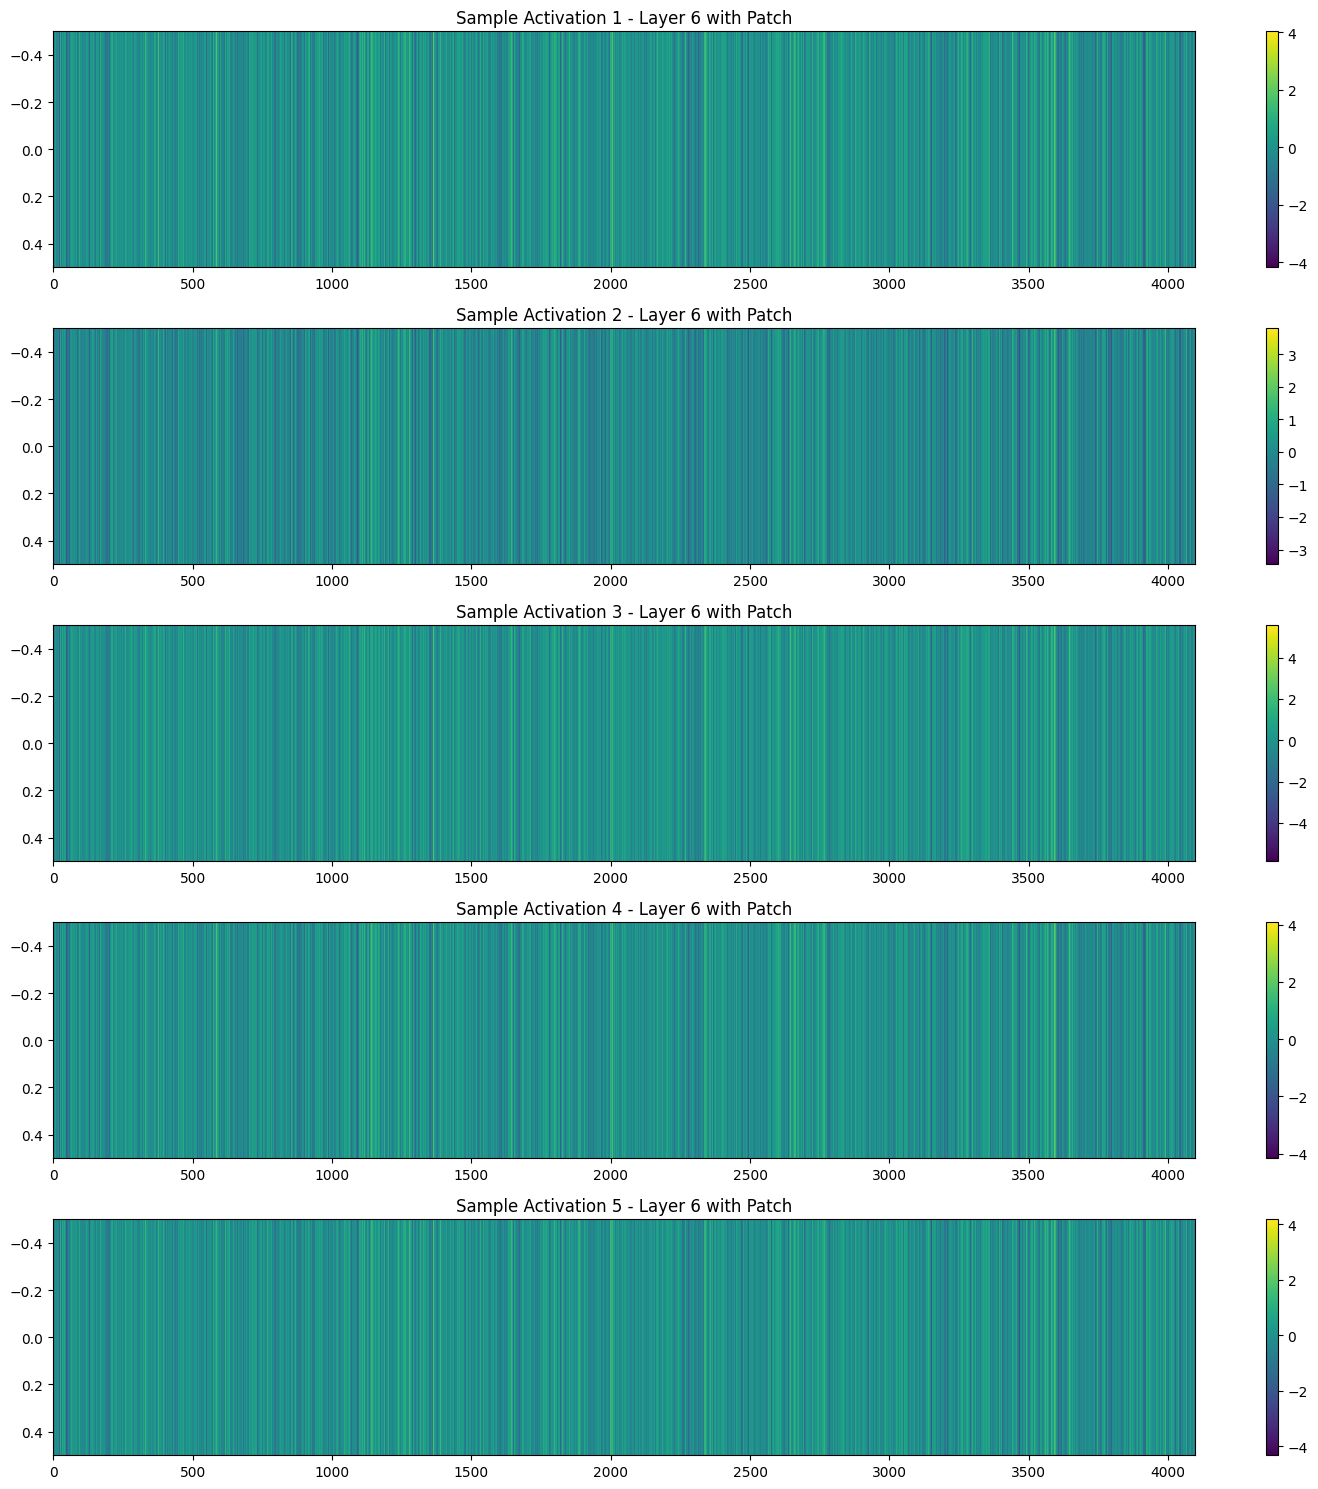


--- Inspection of Layer 6 without Patch Activations ---
CSV Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output/raw_activations_layer_6_without_patch.csv
Shape of activations: (1032, 4096)
First 5 rows of activations:
           0         1         2         3         4         5         6  \
0  0.565544  0.659949 -1.399643 -2.161618  0.656313 -1.799712 -0.038388   
1  0.310540  0.867460 -1.600229 -2.461133  1.493812 -1.709934 -0.045813   
2  0.314097  1.700221 -2.039823 -1.848094  1.130209 -1.432179 -0.242964   
3  0.416695  1.270917 -1.749274 -2.621150  1.652119 -1.420746  0.073068   
4 -0.090546  0.940094 -1.610544 -2.859774  1.586092 -2.030419  0.011916   

          7         8         9  ...      4086      4087      4088      4089  \
0  0.004103  1.003600 -0.489949  ... -1.230192  0.776726 -0.394673 -0.446322   
1  0.402367  2.066101 -0.290138  ... -1.637647  0.973946 -0.536635 -0.682211   
2  0.016431  2.051002 -0.173200  ... -1.690365  0.725872 -1.0

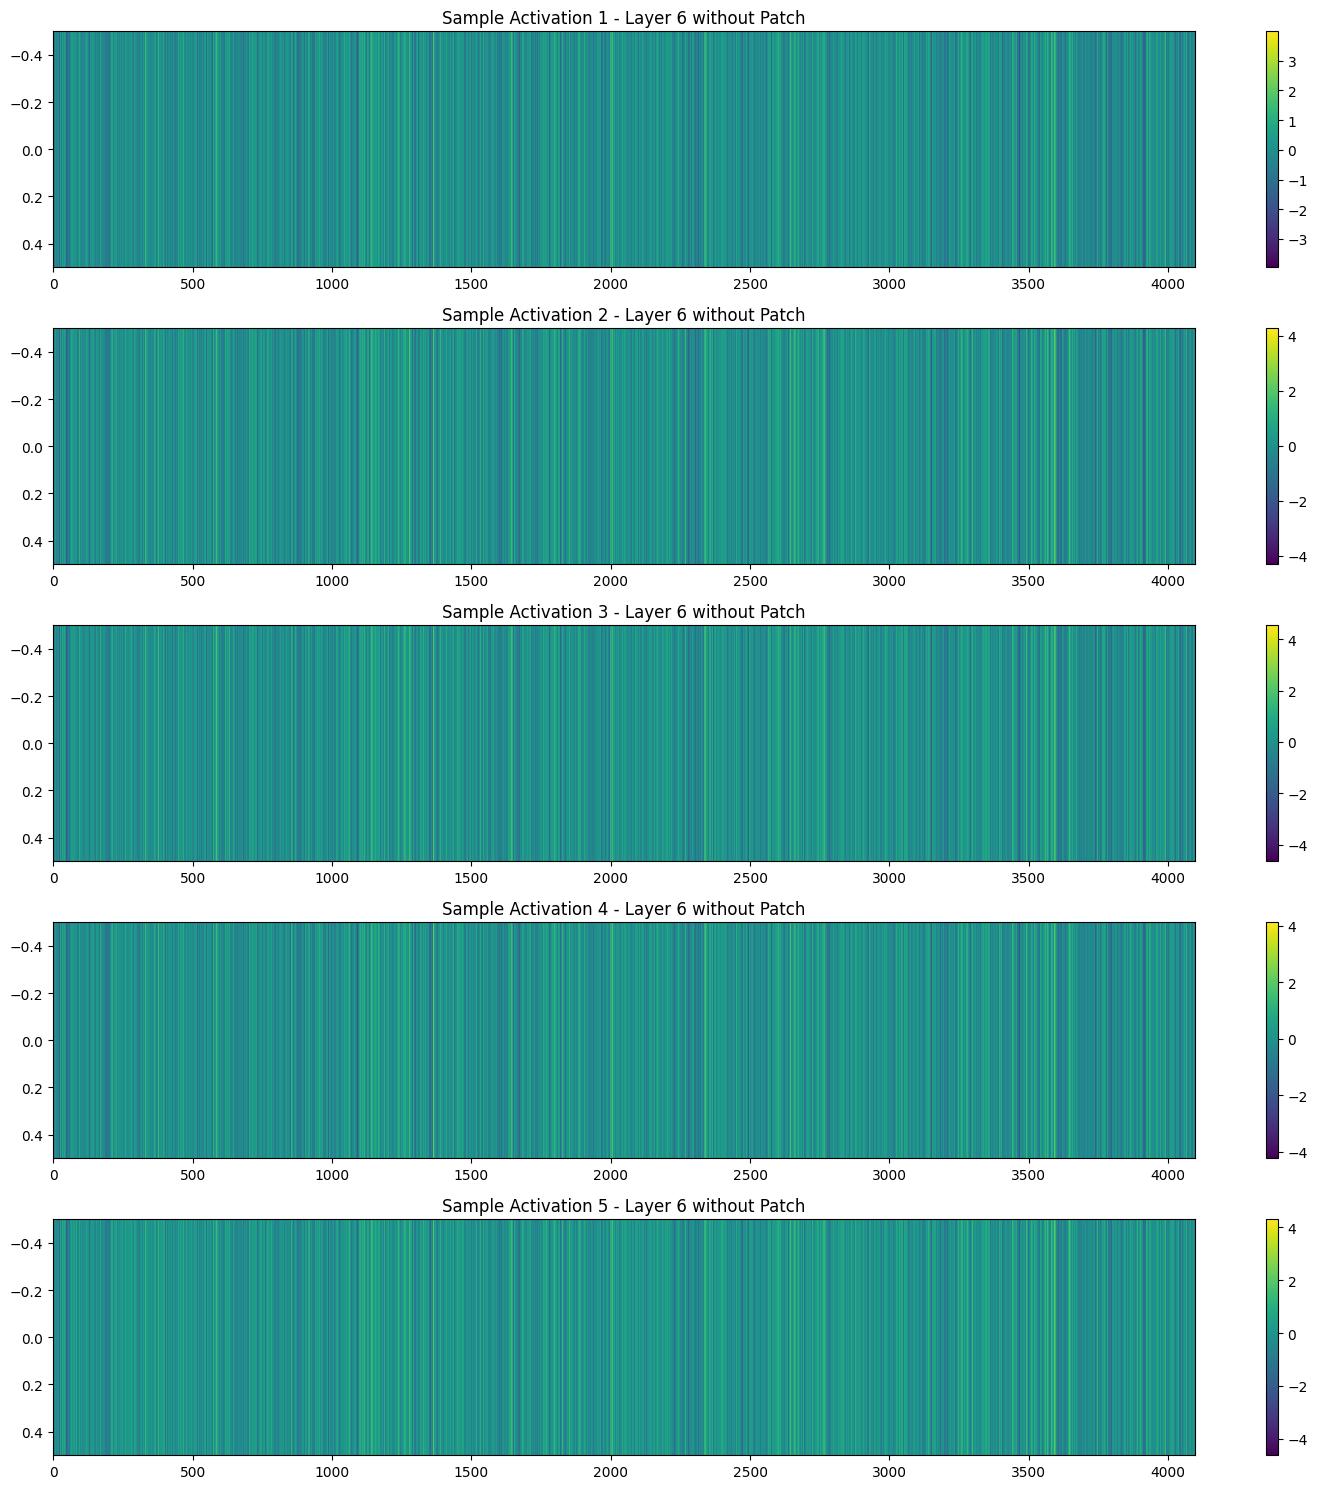


--- Inspection of Layer 5 with Patch Activations ---
CSV Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output/raw_activations_layer_5_with_patch.csv
Shape of activations: (1032, 4096)
First 5 rows of activations:
           0         1         2         3         4         5         6  \
0 -1.996875  0.296932 -0.036366  0.368184  0.879223  0.303163 -1.313569   
1 -1.536669  0.320416 -0.196684  0.594397  0.554659  0.343595 -1.081494   
2 -2.175487  0.253743 -0.114327  0.521689  0.900760 -0.009146 -1.920240   
3 -1.870329  0.259015 -0.310084  0.265051  0.622417  0.308145 -0.882100   
4 -2.340523  0.303926 -0.577890  0.607666  0.737589  0.184682 -1.456509   

          7         8         9  ...      4086      4087      4088      4089  \
0  0.609148  1.622446  0.325247  ... -1.067322  0.780038  0.750288 -0.539115   
1  0.299688  1.116079  0.129811  ... -1.135693  0.679823  0.658736 -0.433674   
2  0.473209  1.797121  0.333642  ... -1.050854  1.206568  0.786114 

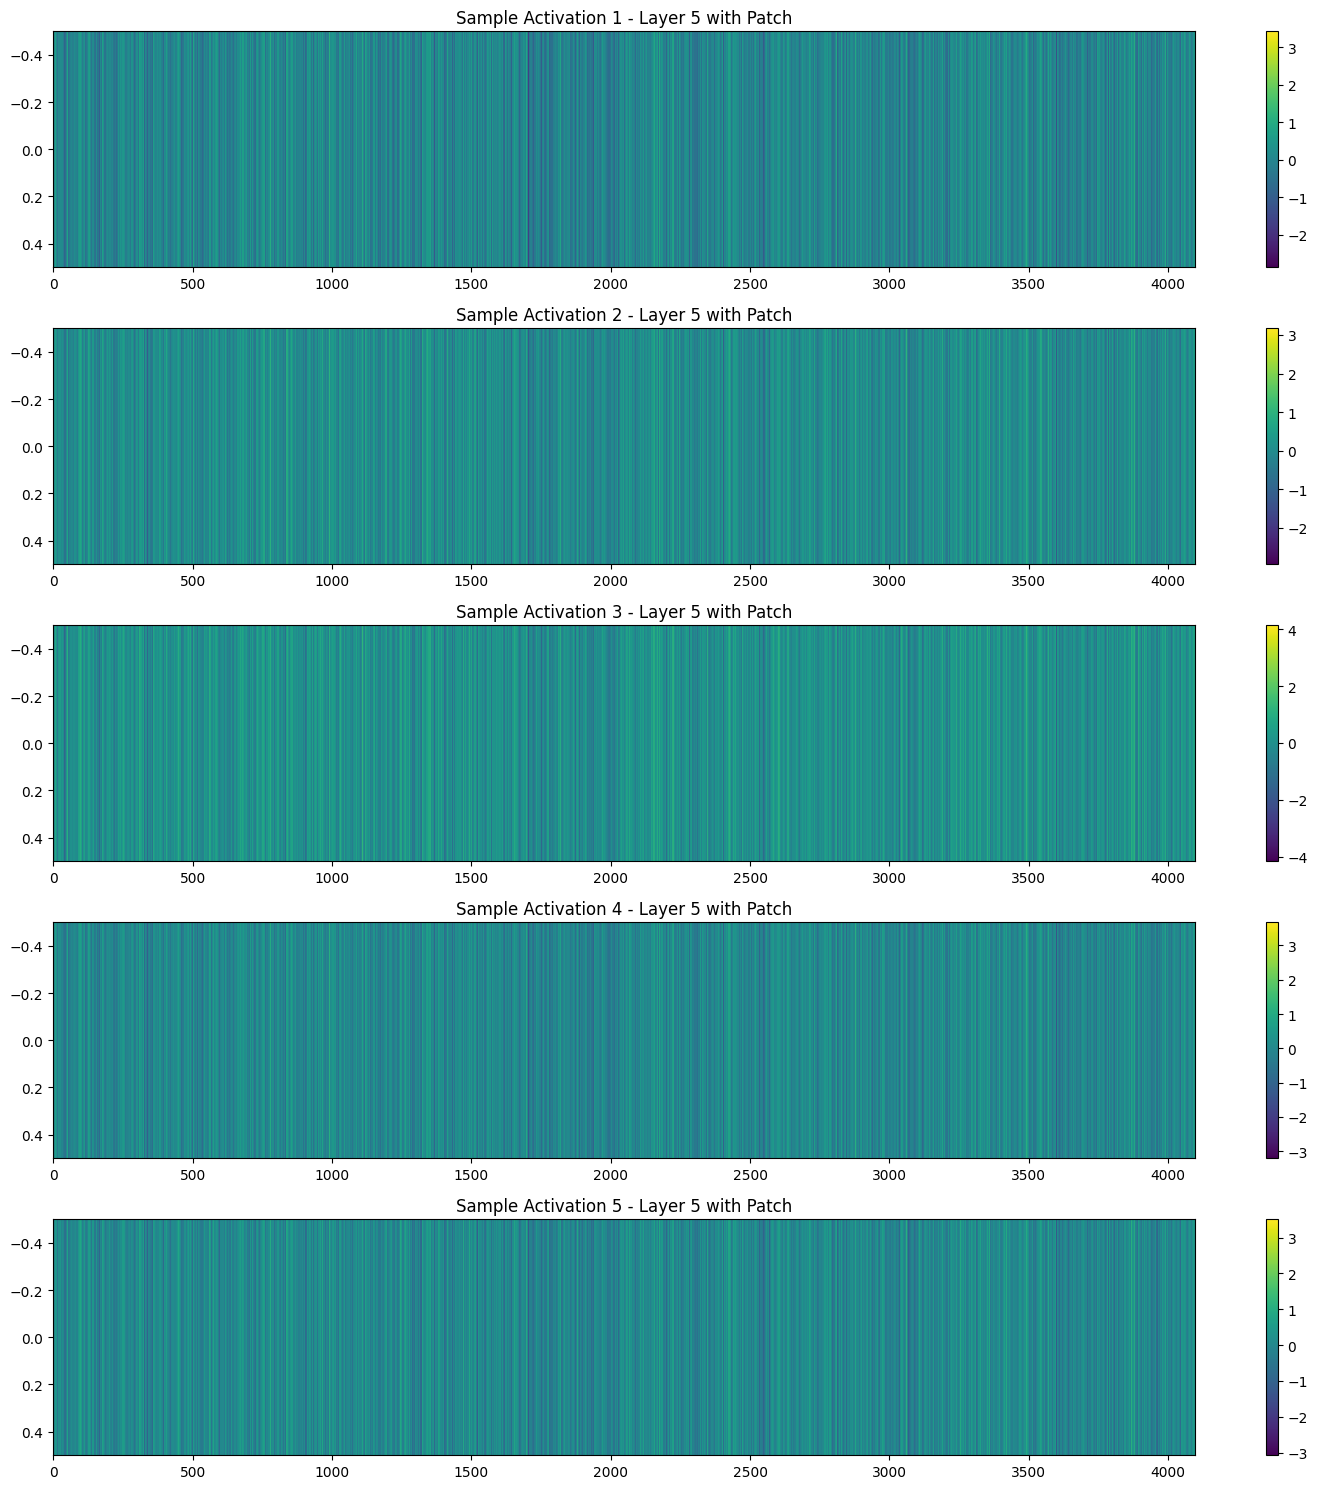


--- Inspection of Layer 5 without Patch Activations ---
CSV Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output/raw_activations_layer_5_without_patch.csv
Shape of activations: (1032, 4096)
First 5 rows of activations:
           0         1         2         3         4         5         6  \
0 -1.693104  0.252075 -0.276397  0.351452  0.736517  0.440329 -1.453123   
1 -2.163448 -0.087223  0.079222  0.624914  0.995719  0.043039 -1.195307   
2 -2.610117  0.290110 -0.496397  0.535626  0.829820 -0.161455 -1.465752   
3 -1.895364  0.475302 -0.091669  0.711906  0.626896  0.174516 -1.301829   
4 -2.228885  0.320241 -0.254821  0.443291  0.724079  0.210870 -1.771200   

          7         8         9  ...      4086      4087      4088      4089  \
0  0.379688  1.245725  0.212353  ... -1.135860  1.108857  1.159366 -0.386704   
1  0.156181  1.729448  0.128918  ... -1.341063  0.962326  0.855084 -0.165556   
2  0.807243  1.594567  0.372865  ... -0.817492  0.855988  0.9

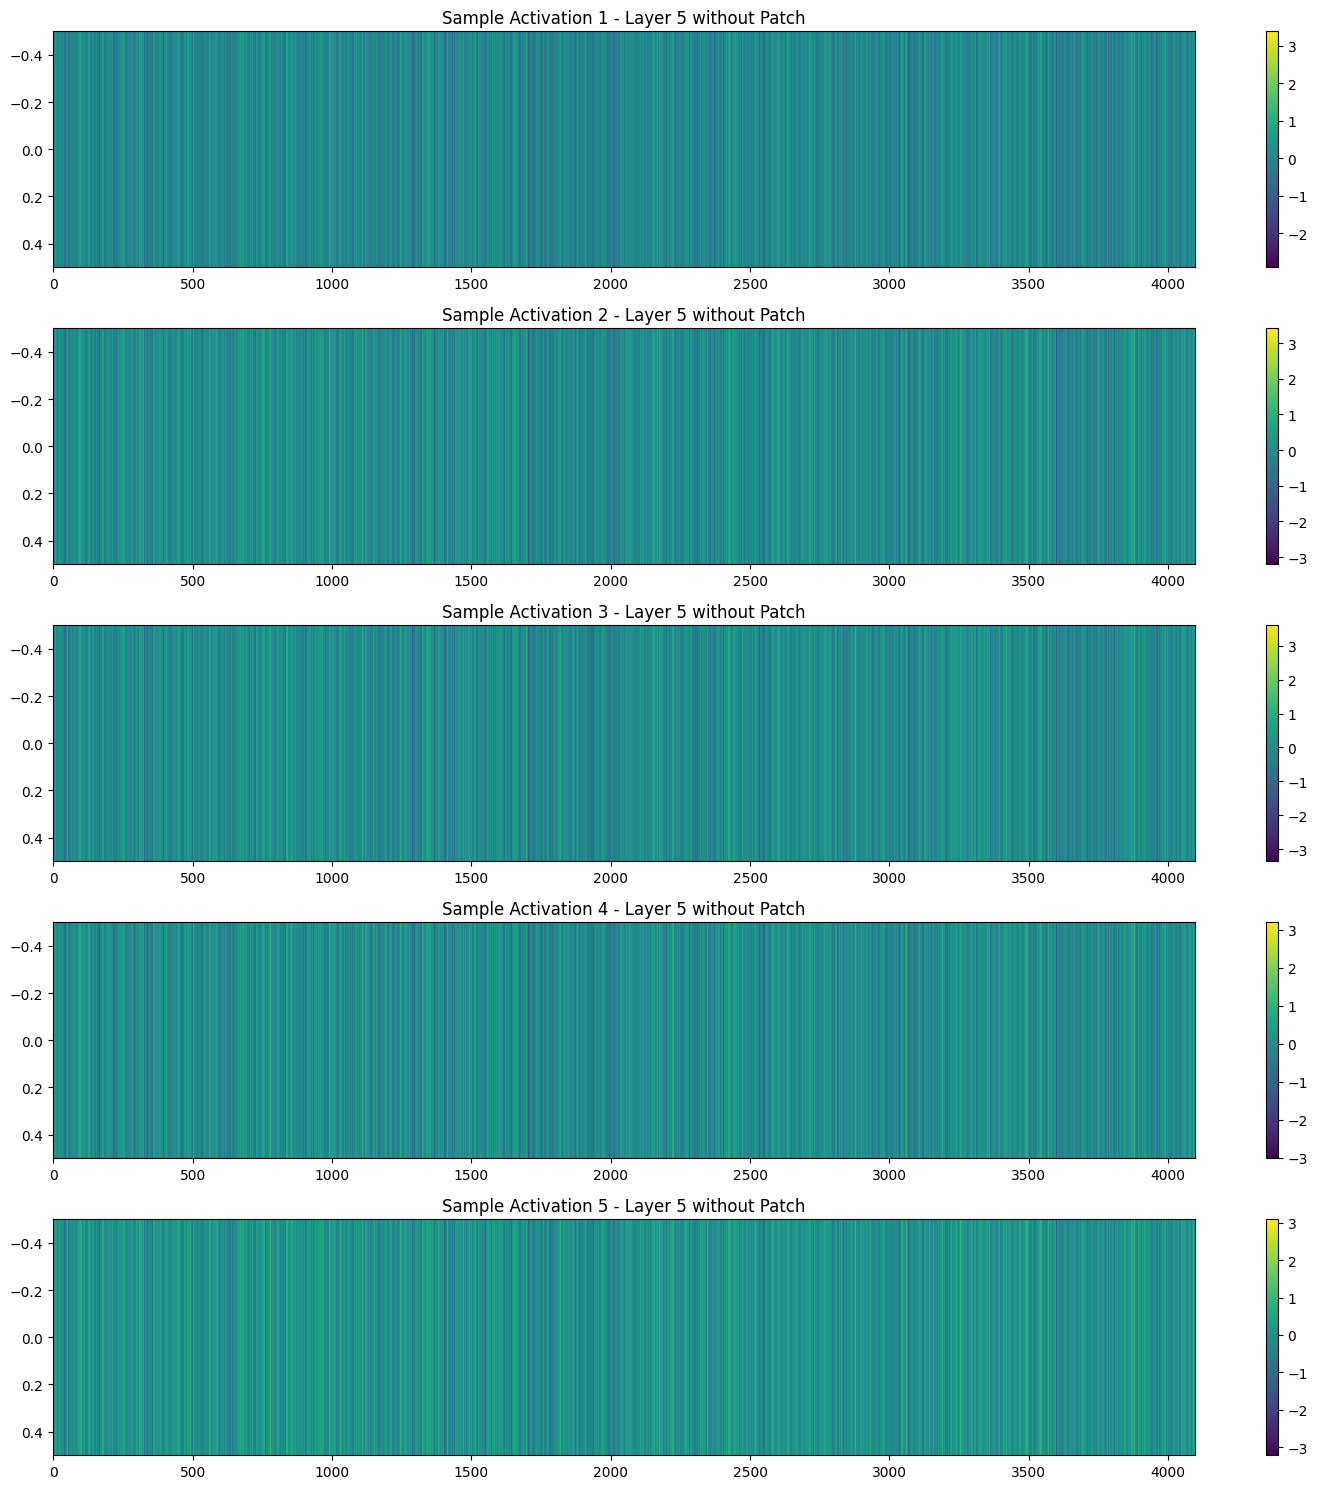

In [21]:


raw_activations_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output"

# Paths for layer 6 (with and without patch)
layer_6_with_patch_path = os.path.join(raw_activations_dir, 'raw_activations_layer_6_with_patch.csv')
layer_6_without_patch_path = os.path.join(raw_activations_dir, 'raw_activations_layer_6_without_patch.csv')

# Paths for layer 5 (with and without patch)
layer_5_with_patch_path = os.path.join(raw_activations_dir, 'raw_activations_layer_5_with_patch.csv')
layer_5_without_patch_path = os.path.join(raw_activations_dir, 'raw_activations_layer_5_without_patch.csv')

# Function to load and inspect CSV activations
def inspect_activations(csv_path, layer_name):
    if not os.path.exists(csv_path):
        print(f"Error: File {csv_path} does not exist.")
        return

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # Display basic information about the activations
    print(f"\n--- Inspection of {layer_name} Activations ---")
    print(f"CSV Path: {csv_path}")
    print("Shape of activations:", df.shape)
    print("First 5 rows of activations:\n", df.head())
    print("Basic statistics:\n", df.describe())

    # Convert to NumPy array for further analysis/plotting
    activations = df.values

    # Plotting a few sample activations as heatmaps
    num_samples = 5
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(activations[i].reshape(1, -1), aspect='auto', cmap='viridis')
        plt.title(f"Sample Activation {i+1} - {layer_name}")
        plt.colorbar()
    plt.tight_layout()
    plt.show()

# Inspect layer 6 activations with and without patch
inspect_activations(layer_6_with_patch_path, "Layer 6 with Patch")
inspect_activations(layer_6_without_patch_path, "Layer 6 without Patch")

# Inspect layer 5 activations with and without patch
inspect_activations(layer_5_with_patch_path, "Layer 5 with Patch")
inspect_activations(layer_5_without_patch_path, "Layer 5 without Patch")



--- Loading and Processing Raw Activations for Layer 5 ---
Loading raw activations from: /content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output/raw_activations_layer_5_with_patch.csv
Loading raw activations from: /content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output/raw_activations_layer_5_without_patch.csv
Loading autoencoder for layer 5 from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/Autoencoders/autoencoder_layer_5.pth with input dimension 4096


<ipython-input-20-cd85e34e8154>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_path))


Autoencoder for layer 5 loaded successfully.
Projecting activations. Shape before projection: (1032, 4096)
Projection successful. Encoded shape: torch.Size([1032, 8192]), Decoded shape: torch.Size([1032, 4096])
Projecting activations. Shape before projection: (1032, 4096)
Projection successful. Encoded shape: torch.Size([1032, 8192]), Decoded shape: torch.Size([1032, 4096])
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/encoded_layer_5_with_patch.csv
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/encoded_layer_5_without_patch.csv
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/decoded_layer_5_with_patch.csv
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/decoded_layer_5_without_patch.csv
Projection completed for layer 5.

--- Loading and Processing Raw Activations for Layer 6 ---
Loading raw activations from: /cont

<ipython-input-20-cd85e34e8154>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_path))


Autoencoder for layer 6 loaded successfully.
Projecting activations. Shape before projection: (1032, 4096)
Projection successful. Encoded shape: torch.Size([1032, 8192]), Decoded shape: torch.Size([1032, 4096])
Projecting activations. Shape before projection: (1032, 4096)
Projection successful. Encoded shape: torch.Size([1032, 8192]), Decoded shape: torch.Size([1032, 4096])
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/encoded_layer_6_with_patch.csv
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/encoded_layer_6_without_patch.csv
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/decoded_layer_6_with_patch.csv
Activations saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/decoded_layer_6_without_patch.csv
Projection completed for layer 6.


<ipython-input-13-5ed241024ce0>:194: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


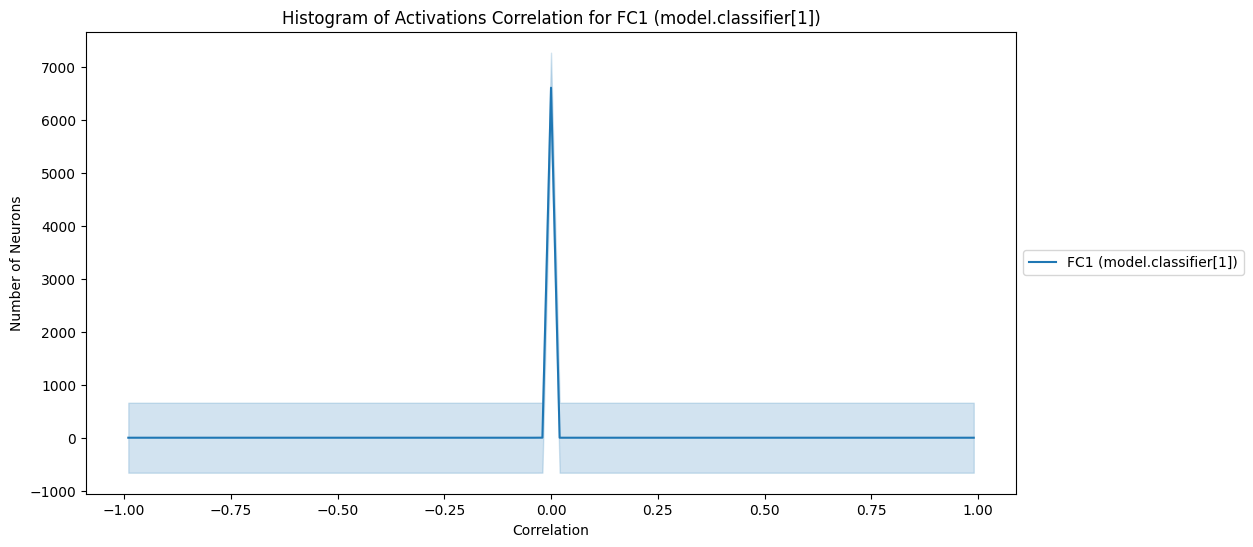

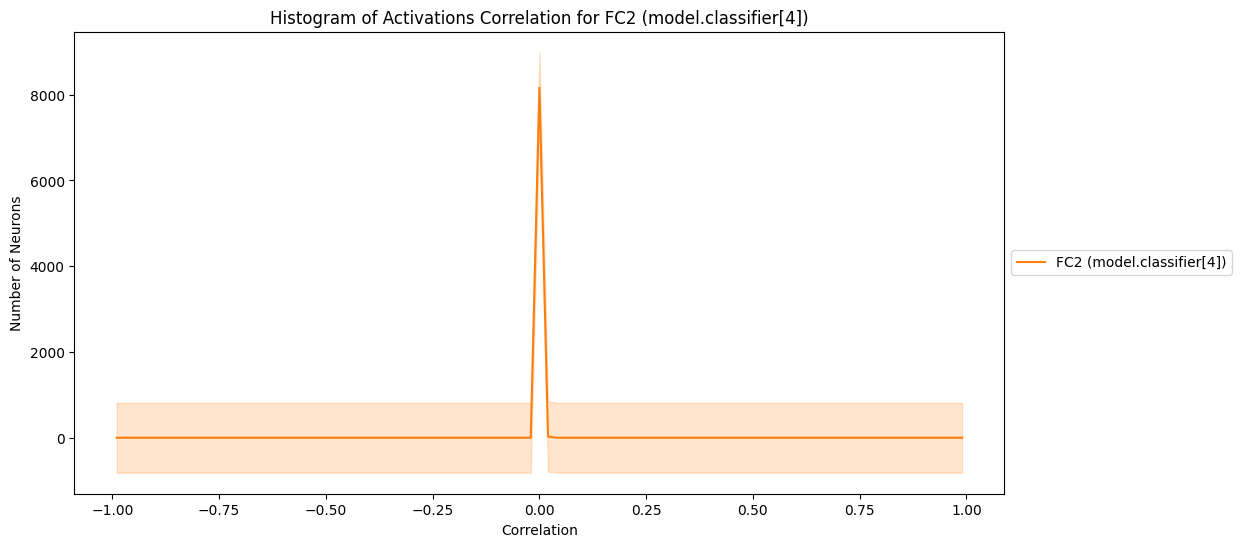

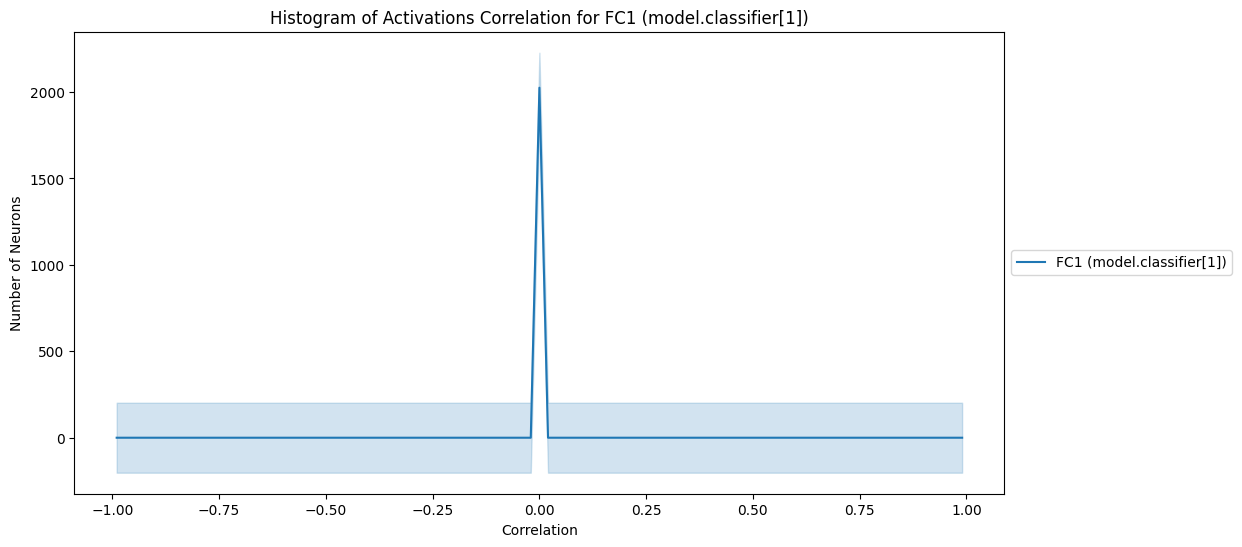

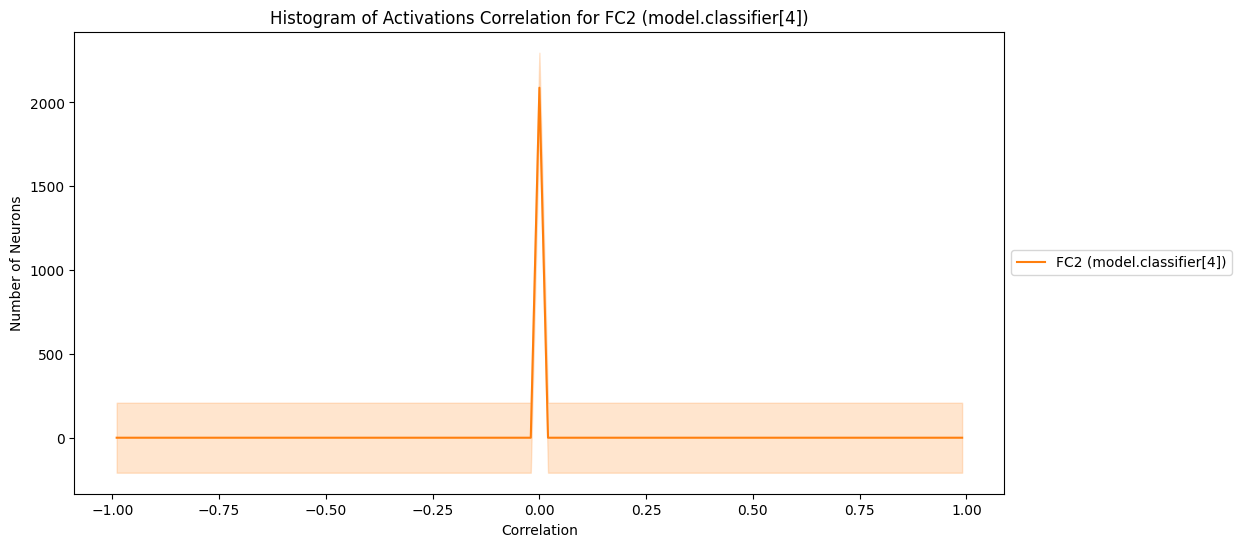

<ipython-input-20-cd85e34e8154>:174: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


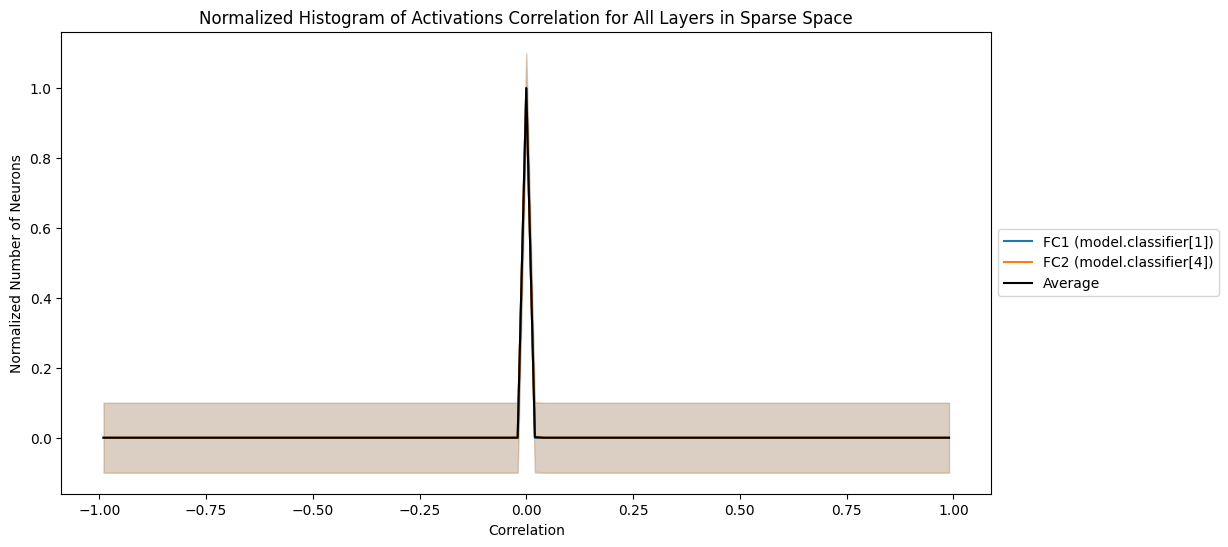

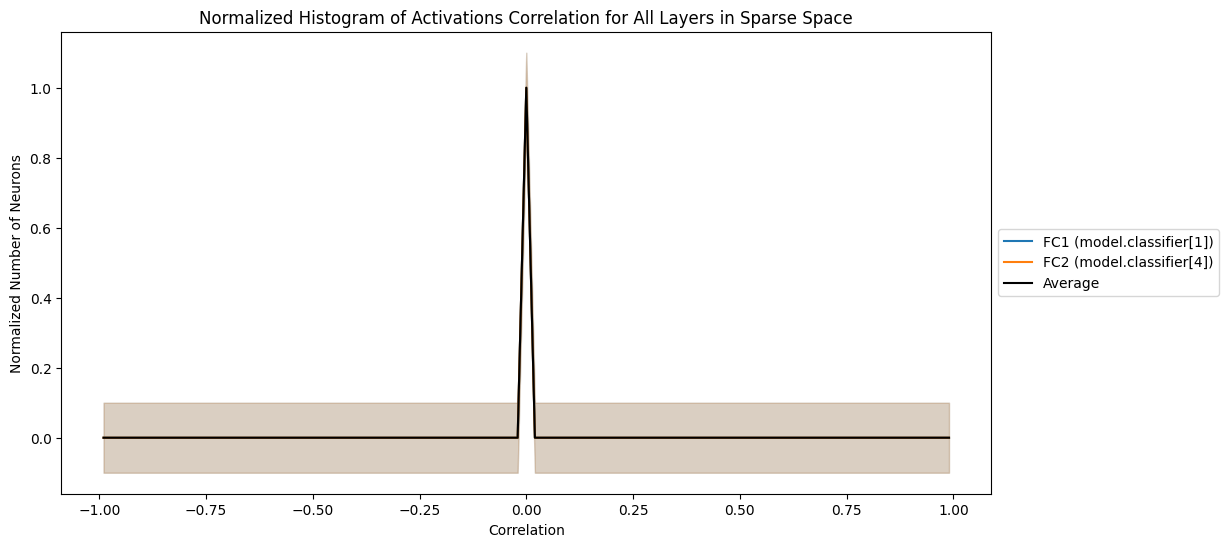

In [20]:
import pandas as pd
import torch
import numpy as np
import os
import gc
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load Autoencoders
def load_autoencoder(layer, encoding_dim, device):
    save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/Autoencoders/'
    save_path = os.path.join(save_sae_dir, f'autoencoder_layer_{layer}.pth')

    # Set the input dimension based on the layer
    layer_input_dims = {
        0: 290400,
        1: 186624,
        2: 64896,
        3: 64896,
        4: 9216,
        5: 4096,
        6: 4096
    }

    if layer not in layer_input_dims:
        print(f"Input dimension for layer {layer} not found. Skipping.")
        return None

    input_dim = layer_input_dims[layer]  # Use the correct input dimension for the layer
    print(f"Loading autoencoder for layer {layer} from {save_path} with input dimension {input_dim}")

    autoencoder = SparseAutoencoder(input_dim, encoding_dim).to(device)

    try:
        autoencoder.load_state_dict(torch.load(save_path))
        autoencoder.eval()
        print(f"Autoencoder for layer {layer} loaded successfully.")
    except Exception as e:
        print(f"Error loading autoencoder for layer {layer}: {e}")
        return None

    return autoencoder

# Function to project activations into sparse space and decode them
def project_and_decode_activations(autoencoder, activations, device):
    print(f"Projecting activations. Shape before projection: {activations.shape}")

    try:
        with torch.no_grad():
            activations_tensor = torch.from_numpy(activations).to(device).float()
            # Get encoded representation
            encoded = autoencoder.encoder(activations_tensor)
            # Get decoded (reconstructed) output
            decoded = autoencoder.decoder(encoded)
        print(f"Projection successful. Encoded shape: {encoded.shape}, Decoded shape: {decoded.shape}")
    except Exception as e:
        print(f"Error during projection: {e}")
        return None, None

    return encoded.cpu().numpy(), decoded.cpu().numpy()

# New function to load previously saved raw activations from CSV
def load_activations_from_csv(layer, with_patch=True):
    """
    Load raw activations from saved CSV files.

    :param layer: Layer number.
    :param with_patch: Boolean, if True load activations with patch, else without patch.
    :return: NumPy array of activations.
    """
    raw_activations_output_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/raw_activations_output"
    suffix = "with_patch" if with_patch else "without_patch"
    file_path = os.path.join(raw_activations_output_dir, f'raw_activations_layer_{layer}_{suffix}.csv')

    if os.path.exists(file_path):
        print(f"Loading raw activations from: {file_path}")
        return pd.read_csv(file_path).values
    else:
        print(f"Error: File {file_path} does not exist.")
        return None

# Updated function to project and decode activations using saved raw activations
def load_and_project_activations(layers, device):
    projected_test_activations = {'two_patch': {}, 'two_no_patch': {}}
    decoded_test_activations = {'two_patch': {}, 'two_no_patch': {}}

    for layer in layers:
        print(f'\n--- Loading and Processing Raw Activations for Layer {layer} ---')

        # Load raw activations from CSV files
        combined_activations_with_patch = load_activations_from_csv(layer, with_patch=True)
        combined_activations_without_patch = load_activations_from_csv(layer, with_patch=False)

        if combined_activations_with_patch is None or combined_activations_without_patch is None:
            print(f"Skipping layer {layer} due to missing raw activations.")
            continue

        # Step 2: Project the averaged activations into the sparse space using autoencoder
        autoencoder = load_autoencoder(layer, encoding_dim=8192, device=device)
        if autoencoder is None:
            print(f"Skipping layer {layer} due to autoencoder loading error.")
            continue

        try:
            # Get both encoded and decoded activations
            encoded_with_patch, decoded_with_patch = project_and_decode_activations(autoencoder, combined_activations_with_patch, device)
            encoded_without_patch, decoded_without_patch = project_and_decode_activations(autoencoder, combined_activations_without_patch, device)

            # Store encoded activations
            projected_test_activations['two_patch'][layer] = encoded_with_patch
            projected_test_activations['two_no_patch'][layer] = encoded_without_patch

            # Store decoded activations
            decoded_test_activations['two_patch'][layer] = decoded_with_patch
            decoded_test_activations['two_no_patch'][layer] = decoded_without_patch

            # Save activations to CSV
            save_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output"
            os.makedirs(save_dir, exist_ok=True)

            # Define paths to save CSV files
            encoded_with_patch_path = os.path.join(save_dir, f'encoded_layer_{layer}_with_patch.csv')
            encoded_without_patch_path = os.path.join(save_dir, f'encoded_layer_{layer}_without_patch.csv')
            decoded_with_patch_path = os.path.join(save_dir, f'decoded_layer_{layer}_with_patch.csv')
            decoded_without_patch_path = os.path.join(save_dir, f'decoded_layer_{layer}_without_patch.csv')

            # Save to CSV
            save_activations_to_csv(encoded_with_patch, encoded_with_patch_path)
            save_activations_to_csv(encoded_without_patch, encoded_without_patch_path)
            save_activations_to_csv(decoded_with_patch, decoded_with_patch_path)
            save_activations_to_csv(decoded_without_patch, decoded_without_patch_path)

        except Exception as e:
            print(f"Error projecting activations for layer {layer}: {e}")
            continue

        print(f"Projection completed for layer {layer}.")
        del autoencoder
        torch.cuda.empty_cache()

    return projected_test_activations, decoded_test_activations

# Function to perform correlation analysis and plot histogram
def plot_histogram_for_layer(layer, layer_name, activations_with_patch, activations_without_patch, color):
    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(activations_without_patch)), np.ones(len(activations_with_patch))])
    combined_activations = np.vstack((activations_without_patch, activations_with_patch))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

# Perform Correlation Analysis for each layer
def perform_correlation_analysis(projected_test_activations, layers_of_interest, layer_names, colors):
    for idx, layer in enumerate(layers_of_interest):
        plot_histogram_for_layer(
            layer,
            layer_names[layer],  # Use layer_names dictionary to get the name of the layer
            projected_test_activations['two_patch'][layer],
            projected_test_activations['two_no_patch'][layer],
            colors[idx]
        )

# Combined plot for all layers
def plot_combined_histogram(layer_names, colors, projected_test_activations, layers_of_interest):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, layer in enumerate(layers_of_interest):
        activations_with_patch = projected_test_activations['two_patch'][layer]
        activations_without_patch = projected_test_activations['two_no_patch'][layer]

        patch_no_patch = np.hstack([np.zeros(len(activations_without_patch)), np.ones(len(activations_with_patch))])
        combined_activations = np.vstack((activations_without_patch, activations_with_patch))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0]) if np.sum(B[0]) != 0 else np.zeros_like(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_names[layer])
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers in Sparse Space')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main Execution

# Define layers of interest
layers_of_interest = [5, 6]
layer_names = {
    0: "Conv1 (model.features[0])",
    1: "Conv2 (model.features[3])",
    2: "Conv3 (model.features[6])",
    3: "Conv4 (model.features[8])",
    4: "Conv5 (model.features[10])",
    5: "FC1 (model.classifier[1])",
    6: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

# Load and project test activations using saved raw activations
projected_test_activations, decoded_test_activations = load_and_project_activations(layers_of_interest, device)

# Perform correlation analysis for encoded activations
perform_correlation_analysis(projected_test_activations, layers_of_interest, layer_names, colors)

# Perform correlation analysis for decoded activations
perform_correlation_analysis(decoded_test_activations, layers_of_interest, layer_names, colors)

# Combined histogram plot for encoded activations
plot_combined_histogram(layer_names, colors, projected_test_activations, layers_of_interest)

# Combined histogram plot for decoded activations
plot_combined_histogram(layer_names, colors, decoded_test_activations, layers_of_interest)


In [15]:
import pandas as pd

def inspect_and_save_activations(encoded_activations, decoded_activations, layer, save_dir):
    """
    Inspect and save encoded and decoded activations to CSV files.

    :param encoded_activations: Dictionary containing encoded activations for 'with_patch' and 'without_patch'.
    :param decoded_activations: Dictionary containing decoded activations for 'with_patch' and 'without_patch'.
    :param layer: The layer number from which activations were extracted.
    :param save_dir: Directory where to save the CSV files.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Define paths to save CSV files
    encoded_with_patch_path = os.path.join(save_dir, f'encoded_layer_{layer}_with_patch.csv')
    encoded_without_patch_path = os.path.join(save_dir, f'encoded_layer_{layer}_without_patch.csv')
    decoded_with_patch_path = os.path.join(save_dir, f'decoded_layer_{layer}_with_patch.csv')
    decoded_without_patch_path = os.path.join(save_dir, f'decoded_layer_{layer}_without_patch.csv')

    # Save encoded activations
    if 'with_patch' in encoded_activations and encoded_activations['with_patch'] is not None:
        df_encoded_with_patch = pd.DataFrame(encoded_activations['with_patch'])
        df_encoded_with_patch.to_csv(encoded_with_patch_path, index=False)
        print(f"Encoded activations with patch saved to {encoded_with_patch_path}")

    if 'without_patch' in encoded_activations and encoded_activations['without_patch'] is not None:
        df_encoded_without_patch = pd.DataFrame(encoded_activations['without_patch'])
        df_encoded_without_patch.to_csv(encoded_without_patch_path, index=False)
        print(f"Encoded activations without patch saved to {encoded_without_patch_path}")

    # Save decoded activations
    if 'with_patch' in decoded_activations and decoded_activations['with_patch'] is not None:
        df_decoded_with_patch = pd.DataFrame(decoded_activations['with_patch'])
        df_decoded_with_patch.to_csv(decoded_with_patch_path, index=False)
        print(f"Decoded activations with patch saved to {decoded_with_patch_path}")

    if 'without_patch' in decoded_activations and decoded_activations['without_patch'] is not None:
        df_decoded_without_patch = pd.DataFrame(decoded_activations['without_patch'])
        df_decoded_without_patch.to_csv(decoded_without_patch_path, index=False)
        print(f"Decoded activations without patch saved to {decoded_without_patch_path}")

    # Inspect activations
    for name, activation in [('Encoded with patch', encoded_activations['with_patch']),
                             ('Encoded without patch', encoded_activations['without_patch']),
                             ('Decoded with patch', decoded_activations['with_patch']),
                             ('Decoded without patch', decoded_activations['without_patch'])]:
        if activation is not None:
            print(f"\n{name} - Layer {layer}")
            print(f"Shape: {activation.shape}")
            print(f"Mean: {np.mean(activation)}, Std: {np.std(activation)}, Min: {np.min(activation)}, Max: {np.max(activation)}")
        else:
            print(f"\n{name} - Layer {layer} is not available.")


# Example usage of `inspect_and_save_activations`
# Assuming the projected_test_activations and decoded_test_activations dictionaries are available
save_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output"

# For each layer, inspect and save activations
for layer in layers_of_interest:
    # Get encoded and decoded activations for the current layer
    encoded_activations = {
        'with_patch': projected_test_activations['two_patch'].get(layer),
        'without_patch': projected_test_activations['two_no_patch'].get(layer)
    }

    decoded_activations = {
        'with_patch': decoded_test_activations['two_patch'].get(layer),
        'without_patch': decoded_test_activations['two_no_patch'].get(layer)
    }

    # Call the inspection and saving function
    inspect_and_save_activations(encoded_activations, decoded_activations, layer, save_dir)


Encoded activations with patch saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/encoded_layer_5_with_patch.csv
Encoded activations without patch saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/encoded_layer_5_without_patch.csv
Decoded activations with patch saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/decoded_layer_5_with_patch.csv
Decoded activations without patch saved to /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_output/decoded_layer_5_without_patch.csv

Encoded with patch - Layer 5
Shape: (1032, 8192)
Mean: 0.3659226596355438, Std: 0.4050765335559845, Min: 0.0, Max: 4.0583415031433105

Encoded without patch - Layer 5
Shape: (1032, 8192)
Mean: 0.3657532334327698, Std: 0.40485984086990356, Min: 0.0, Max: 4.063176155090332

Decoded with patch - Layer 5
Shape: (1032, 4096)
Mean: 0.3479425311088562, Std: 0.5337561964988708, Min: 0.0, Max: 3.720280408859253

Decoded without 

In [ ]:
import pandas as pd

def save_activations_to_csv(activations, file_path):
    """
    Save activations to a CSV file.

    :param activations: NumPy array containing activations.
    :param file_path: Path to save the CSV file.
    """
    # Convert activations to a DataFrame
    df = pd.DataFrame(activations)
    # Save DataFrame to CSV
    df.to_csv(file_path, index=False)
    print(f"Activations saved to {file_path}")


In [12]:
from scipy.stats import ttest_ind

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(projected_activations):
    t_test_results = {}
    for layer, data in projected_activations['two_patch'].items():
        wp_activations = np.array(projected_activations['two_patch'][layer])  # With patch
        wo_activations = np.array(projected_activations['two_no_patch'][layer])  # Without patch

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)


# Main Execution to perform t-tests on the projected activations
t_test_results = perform_two_sample_t_tests(projected_test_activations)
print_t_test_results(t_test_results)


Layer 5:
  WP Activations:
    Mean: 0.3659
  WO Activations:
    Mean: 0.3658
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 0.00%
    Percentage of neurons with raw p-value <= 0.02: 0.00%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 0.00%
    Percentage of neurons with adjusted p-value <= 0.02: 0.00%
--------------------------------------------------
Layer 6:
  WP Activations:
    Mean: 0.5196
  WO Activations:
    Mean: 0.5193
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 0.00%
    Percentage of neurons with raw p-value <= 0.02: 0.00%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 0.00%
    Percentage of neurons with adjusted p-value <= 0.02: 0.00%
--------------------------------------------------
